In [1]:
# the building we want to run
building_id = 2
# Price of the panel
price = 106
# this will create a folder which will save the files
iteration = 30
# optimization method
# Currently implemented are: rbf-net, rbf-cost, ga-50, ga-20
opt_method = "rbf-cost"
# Number of evaluations:
number_of_opt_evaluations = 100
# number of run
run_i=2
# Some cluster solution
base_path=""

In [2]:
# Parameters
opt_method = "ga-50"
number_of_opt_evaluations = 100
run_i = 5


In [3]:
# Important file names 
# This is where the optimal solution or final population of solutions is provided
ga_file = "panel_{}_{}_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)
# here we store every run that optmizer runs
ga_proc = "panel_{}_{}_archive_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)
# Here we combine the optimal solution with the addition information that we are interested in.
ga_fina = "panel_{}_{}_processed_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)

In [4]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = base_path+'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = base_path+'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)
ga_file=ga_output_dir+ga_file
ga_proc=ga_output_dir+ga_proc
ga_fina=ga_output_dir+ga_fina



# Weather file
epw_file   = base_path+'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = base_path+'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [5]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
error_dir  = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
ensure_dir(output_dir)

# EHUB
ehub_dir   = base_path+'ehub/output_ehub_excel/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = base_path+"rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
ep_path="/home/theochri/projects/def-revins/theochri/EnergyPlus/"

# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [8]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir,
                                   epw_file=epw_file, err_dir=error_dir,ep_path=ep_path)

/home/theochri/projects/def-revins/theochri/EnergyPlus/


## the North Axis
The north axis gets grabbed automatically from the idf.

In [9]:
pvbuilding.North_Axis

0.0

In [10]:
pvbuilding.Building_Information


Building,
    Ref Bldg Small Office New2004_v1.3_5.0,    !- Name
    0.0,                      !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [11]:
# Determine the hourly electricity use
pvbuilding.run_ep(ep_path=ep_path)

EnergyPlus is found in the path: /home/theochri/projects/def-revins/theochri/EnergyPlus/


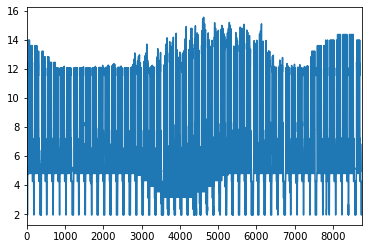

In [12]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [13]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 2,059.63
14.35220436334519


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [14]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 599 m2
Roof area is up 29 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [15]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 1.9317841529846191 sec


ERROR:root:Finished Generation of Irradiance


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 1.9240810871124268 sec


ERROR:root:Finished Generation of Irradiance


0.0


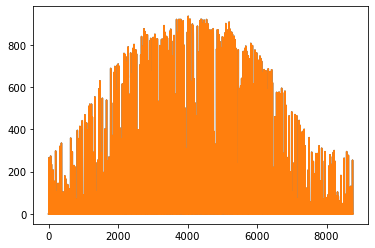

In [16]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)
Loading the model
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.712682008743286 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7191336154937744 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.726794958114624 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 266 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [307.537, 0.0, 0.0]


ERROR:ga_logger:Cost: 3187.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,188 per year


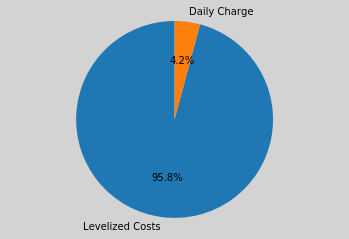

Total roof area of the  building: 599 m2
Total roof area used 473 m2
Percentage: 79.0%


In [17]:
from pv_model import pvModel
# this was the optimal solution
pan_vals = (155,175,260,26,36,36,0.65,0.7,0.9)
gcr=(0.65,0.7,0.9)
print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.

default_settings = {
                    'name': 'glpk-cluster',
                    'solver_path': '/home/theochri/ENV/bin/glpsol',
                    'options': {
                                'mipgap': 0.05,
                               },
                    }
# preload the excel
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels,
                           factor_multiplier=3,
                           solver_settings=default_settings)
my_model.eval_model(pan_vals,106,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [18]:
my_model.energyIm

61845.7

In [19]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    0.0
dtype: float64

In [20]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr         4805.72
Aug         5680.08
Dec         5274.31
Feb         4713.95
Jan         5340.70
Jul         5200.48
Jun         5124.65
Mar         5319.26
May         5015.79
Nov         5153.19
Oct         5154.70
Sep         5062.88
monthly_import    61845.71
dtype: float64
61845.7
     monthly_export
Apr         6899.34
Aug         8061.75
Dec         1351.01
Feb         2744.22
Jan         1541.01
Jul         9311.54
Jun         7990.47
Mar         4415.47
May         8175.98
Nov         1793.90
Oct         3229.92
Sep         6330.97
monthly_export    61845.58
dtype: float64
61845.6
133.042


In [21]:
my_model.solveResults['solution']['daily_charge_c']

133.042

In [22]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng             0
Grid                 1
Invertor             1
PV0                  1
PV1                  0
PV2                  0

In [23]:
my_model.solveResults['solution']['any_above_35']

0

In [24]:
my_model.solveResults['solution']['a150_or_a550']

0

# (D) GA - Optimize the model

In [25]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

In [26]:
# preload the excel
from pyehub.excel_to_request_format import convert

request_format = convert(excel_file=ehub_file)

In [27]:
import logging
lrun       = logging.getLogger('Runs_logger')
hdlrun       = logging.FileHandler('runs_logger.txt')
formatterrun  = logging.Formatter('%(asctime)s %(message)s')
hdlrun.setFormatter(formatterrun)
lrun.addHandler(hdlrun) 
lrun.setLevel(logging.ERROR)

In [28]:
import time
t1=time.time()

pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                         range_tilt=range_tilt,
                         range_gcr=range_gcr,
                         pvpanel=pvpanel,
                         price=price,
                         store_file=ga_file,
                         ehub_request=request_format,
                         res_file=res_file,
                         pvbuilding=pvbuilding,
                         roof_area_per_unit_capacity=roof_area_per_unit_capacity,
                         ga_proc=ga_proc,
                         solver_settings=default_settings)



ERROR:optimizer_logger:Found the solver set


/home/theochri/paper_pusher/lib/python3.6/site-packages/besos/evaluator.py:395: FutureWarning: EvaluatorSR has been renamed as EvaluatorGeneric with same functionaility. EvaluatorSR will be removed in a future release.
  warn(msg, FutureWarning)
ERROR:optimizer_logger:Started {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:0


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (229.15332886854162, 215.68873169528393, 238.12069939530562, 54.39238183729163, 37.51570328765201, 55.806909314810504, 0.6968341083635892, 0.5734586553143787, 0.8271817586960373)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 229
                                           a tilt of 54.4
                                           and a gcr of 0.697


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6737165451049805 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 216
                                           a tilt of 37.5
                                           and a gcr of 0.573


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.748983383178711 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 238
                                           a tilt of 55.8
                                           and a gcr of 0.827


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7502899169921875 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 264 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 115s


ERROR:ga_logger:panel relevance: [0.0, 317.389, 0.0]


ERROR:ga_logger:Cost: 3285.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,285 per year


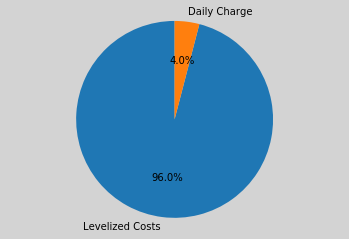

Total roof area of the  building: 599 m2
Total roof area used 553 m2
Percentage: 92.4%
succes
[[229.15332886854162, 215.68873169528393, 238.12069939530562, 54.39238183729163, 37.51570328765201, 55.806909314810504, 0.6968341083635892, 0.5734586553143787, 0.8271817586960373, 3285.42, 317.389, 0.0, 317.389, 0.0, {'Levelized Costs': 3152.371, 'Energy Charge': 0.0070000000001755325, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6002752251, 61845.7, 553.464]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (151.5647645304881, 224.30012406141915, 256.95305215754354, 25.165571693017725, 48.897647116243355, 25.16568988504828, 0.687354091057236, 0.4368736360683147, 0.7163952246755938)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 152
                                           a tilt of 25.2
                                           and a gcr of 0.687


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.930800199508667 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 224
                                           a tilt of 48.9
                                           and a gcr of 0.437


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9880030155181885 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 257
                                           a tilt of 25.2
                                           and a gcr of 0.716


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3317697048187256 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 249 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [311.383, 0.0, 0.0]


ERROR:ga_logger:Cost: 3225.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,226 per year


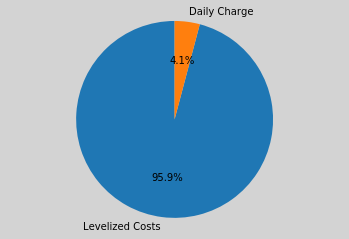

Total roof area of the  building: 599 m2
Total roof area used 453 m2
Percentage: 75.7%
succes
[[151.5647645304881, 224.30012406141915, 256.95305215754354, 25.165571693017725, 48.897647116243355, 25.16568988504828, 0.687354091057236, 0.4368736360683147, 0.7163952246755938, 3225.77, 311.383, 311.383, 0.0, 0.0, {'Levelized Costs': 3092.719, 'Energy Charge': 0.009000000000185082, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60067490992, 61845.7, 453.017]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (99.24943257303957, 258.48172183680765, 105.8822059776145, 14.293661594629068, 29.278162764291416, 24.672340449678593, 0.7887986398560423, 0.530864162267098, 0.8485957986859225)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 99
                                           a tilt of 14.3
                                           and a gcr of 0.789


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.756772994995117 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 258
                                           a tilt of 29.3
                                           and a gcr of 0.531


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7885100841522217 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 106
                                           a tilt of 24.7
                                           and a gcr of 0.849


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6985461711883545 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 250 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [345.924, 0.0, 0.0]


ERROR:ga_logger:Cost: 3568.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,569 per year


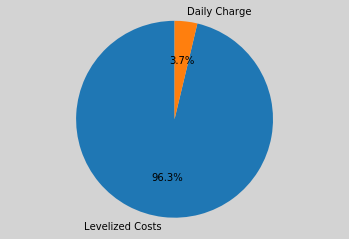

Total roof area of the  building: 599 m2
Total roof area used 439 m2
Percentage: 73.2%
succes
[[99.24943257303957, 258.48172183680765, 105.8822059776145, 14.293661594629068, 29.278162764291416, 24.672340449678593, 0.7887986398560423, 0.530864162267098, 0.8485957986859225, 3568.85, 345.924, 345.924, 0.0, 0.0, {'Levelized Costs': 3435.7899999999995, 'Energy Charge': 0.018000000000256478, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60194931012, 61845.7, 438.546]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (96.09346407510677, 168.9508752764053, 158.61497186404077, 11.658601887239245, 37.965522873743204, 54.300705588056445, 0.8763173155820756, 0.29900785308955846, 0.4284222021604751)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 96
                                           a tilt of 11.7
                                           and a gcr of 0.876


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.744986057281494 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 169
                                           a tilt of 38.0
                                           and a gcr of 0.299


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7498321533203125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 159
                                           a tilt of 54.3
                                           and a gcr of 0.428


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8127541542053223 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 255 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [229.295, 100.797, 0.0]


ERROR:ga_logger:Cost: 3411.6


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,412 per year


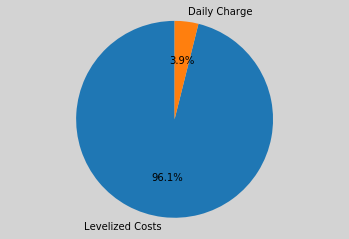

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[96.09346407510677, 168.9508752764053, 158.61497186404077, 11.658601887239245, 37.965522873743204, 54.300705588056445, 0.8763173155820756, 0.29900785308955846, 0.4284222021604751, 3411.6, 330.092, 229.295, 100.797, 0.0, {'Levelized Costs': 3278.551, 'Energy Charge': 0.007000000000118689, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60187715988, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (135.03275088372624, 174.93517463363173, 154.39122623939602, 23.344435359087182, 17.583416586178753, 39.32876482868124, 0.8767007790006329, 0.7454185180679711, 0.6992494359855693)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 23.3
                                           and a gcr of 0.877


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7936487197875977 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 17.6
                                           and a gcr of 0.745


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8954739570617676 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 154
                                           a tilt of 39.3
                                           and a gcr of 0.699


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0002095699310303 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 241 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [0.0, 308.671, 0.0]


ERROR:ga_logger:Cost: 3198.84


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,199 per year


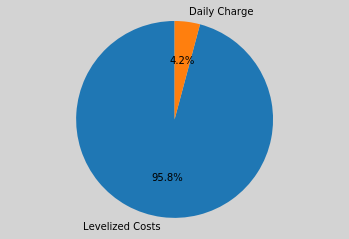

Total roof area of the  building: 599 m2
Total roof area used 414 m2
Percentage: 69.2%
succes
[[135.03275088372624, 174.93517463363173, 154.39122623939602, 23.344435359087182, 17.583416586178753, 39.32876482868124, 0.8767007790006329, 0.7454185180679711, 0.6992494359855693, 3198.84, 308.671, 0.0, 308.671, 0.0, {'Levelized Costs': 3065.7850000000003, 'Energy Charge': 0.012999999999919964, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601816863295, 61845.7, 414.09]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (239.24816128589026, 127.22767030334046, 178.55894400437154, 54.94480223218174, 9.07283284240107, 19.102127678104036, 0.32591308577657396, 0.30674511509680097, 0.7117687013007139)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 239
                                           a tilt of 54.9
                                           and a gcr of 0.326


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.772005319595337 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 127
                                           a tilt of 9.1
                                           and a gcr of 0.307


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7566850185394287 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 179
                                           a tilt of 19.1
                                           and a gcr of 0.712


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7834055423736572 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 245 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 306.069]


ERROR:ga_logger:Cost: 3172.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,173 per year


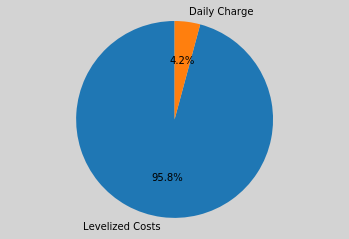

Total roof area of the  building: 599 m2
Total roof area used 430 m2
Percentage: 71.8%
succes
[[239.24816128589026, 127.22767030334046, 178.55894400437154, 54.94480223218174, 9.07283284240107, 19.102127678104036, 0.32591308577657396, 0.30674511509680097, 0.7117687013007139, 3172.99, 306.069, 0.0, 0.0, 306.069, {'Levelized Costs': 3039.9399999999996, 'Energy Charge': 0.008000000000322416, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59996521361, 61845.7, 430.011]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (255.51833424642564, 232.81196123848133, 176.33022165560564, 25.773044436967094, 46.33991207467531, 25.507504975802757, 0.5992865688243203, 0.8962382471790313, 0.5185333031746143)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 256
                                           a tilt of 25.8
                                           and a gcr of 0.599


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6891651153564453 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 233
                                           a tilt of 46.3
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.65808367729187 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 176
                                           a tilt of 25.5
                                           and a gcr of 0.519


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.730180025100708 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 263 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.743]


ERROR:ga_logger:Cost: 3080.37


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,080 per year


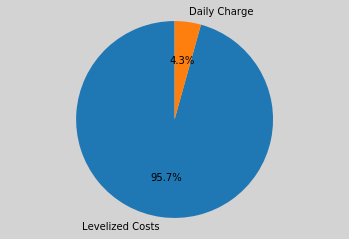

Total roof area of the  building: 599 m2
Total roof area used 572 m2
Percentage: 95.6%
succes
[[255.51833424642564, 232.81196123848133, 176.33022165560564, 25.773044436967094, 46.33991207467531, 25.507504975802757, 0.5992865688243203, 0.8962382471790313, 0.5185333031746143, 3080.37, 296.743, 0.0, 0.0, 296.743, {'Levelized Costs': 2947.3190000000004, 'Energy Charge': 0.008999999999673491, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601551779924, 61845.7, 572.273]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (189.21992737212526, 231.6470312834316, 164.06938372082783, 36.529689972609084, 38.15206656942083, 16.12058362276415, 0.8488239350331481, 0.6449253884979955, 0.5755549328141043)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 189
                                           a tilt of 36.5
                                           and a gcr of 0.849


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.807023763656616 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 232
                                           a tilt of 38.2
                                           and a gcr of 0.645


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8064634799957275 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 164
                                           a tilt of 16.1
                                           and a gcr of 0.576


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8048410415649414 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 256 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 123s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 305.412]


ERROR:ga_logger:Cost: 3166.47


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,166 per year


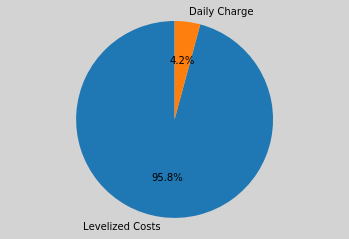

Total roof area of the  building: 599 m2
Total roof area used 531 m2
Percentage: 88.6%
succes
[[189.21992737212526, 231.6470312834316, 164.06938372082783, 36.529689972609084, 38.15206656942083, 16.12058362276415, 0.8488239350331481, 0.6449253884979955, 0.5755549328141043, 3166.47, 305.412, 0.0, 0.0, 305.412, {'Levelized Costs': 3033.417, 'Energy Charge': 0.010999999999967258, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601085099785, 61845.7, 530.639]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (208.12782796077704, 245.17034421216255, 95.17389564243523, 41.87915422316412, 47.371232641318194, 42.18807346532373, 0.6287685263809302, 0.31955379544705254, 0.5134583655375575)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 208
                                           a tilt of 41.9
                                           and a gcr of 0.629


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7649974822998047 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 47.4
                                           and a gcr of 0.320


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.129997730255127 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 42.2
                                           and a gcr of 0.513


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9610259532928467 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 225 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [319.705, 0.0, 0.0]


ERROR:ga_logger:Cost: 3308.43


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,308 per year


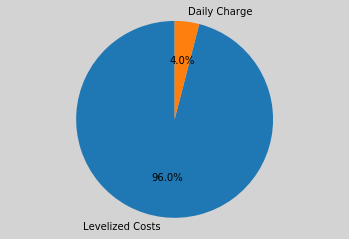

Total roof area of the  building: 599 m2
Total roof area used 508 m2
Percentage: 84.9%
succes
[[208.12782796077704, 245.17034421216255, 95.17389564243523, 41.87915422316412, 47.371232641318194, 42.18807346532373, 0.6287685263809302, 0.31955379544705254, 0.5134583655375575, 3308.43, 319.705, 319.705, 0.0, 0.0, {'Levelized Costs': 3175.3779999999997, 'Energy Charge': 0.010000000000161435, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59989272892, 61845.7, 508.462]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (245.0187260884277, 261.80769511330755, 138.31546628236597, 17.962740405689917, 28.848379860779477, 8.56839354189001, 0.7761475432626976, 0.7142064642007446, 0.3673309587448506)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 18.0
                                           and a gcr of 0.776


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7862844467163086 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 262
                                           a tilt of 28.8
                                           and a gcr of 0.714


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6579184532165527 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 138
                                           a tilt of 8.6
                                           and a gcr of 0.367


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6766490936279297 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 262 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [213.973, 0.0, 118.676]


ERROR:ga_logger:Cost: 3436.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,437 per year


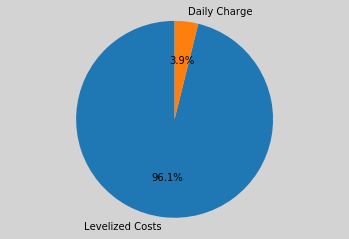

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[245.0187260884277, 261.80769511330755, 138.31546628236597, 17.962740405689917, 28.848379860779477, 8.56839354189001, 0.7761475432626976, 0.7142064642007446, 0.3673309587448506, 3436.99, 332.649, 213.973, 0.0, 118.676, {'Levelized Costs': 3303.932, 'Energy Charge': 0.016000000000076398, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600681177784, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (257.2307776557823, 245.5500155966094, 260.05997312569593, 3.6913239744931583, 24.3541989355938, 31.758214677783837, 0.6336427107965084, 0.2838348645291619, 0.7592173555096879)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 257
                                           a tilt of 3.7
                                           and a gcr of 0.634


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.310333490371704 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 246
                                           a tilt of 24.4
                                           and a gcr of 0.284


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.842433214187622 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 31.8
                                           and a gcr of 0.759


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1114320755004883 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 246 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [297.402, 36.7307, 0.0]


ERROR:ga_logger:Cost: 3451.73


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,452 per year


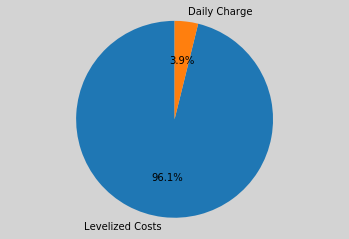

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[257.2307776557823, 245.5500155966094, 260.05997312569593, 3.6913239744931583, 24.3541989355938, 31.758214677783837, 0.6336427107965084, 0.2838348645291619, 0.7592173555096879, 3451.73, 334.1327, 297.402, 36.7307, 0.0, {'Levelized Costs': 3318.671, 'Energy Charge': 0.017000000000166438, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60193013679, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (91.72666968428456, 138.9835948439295, 172.10333139376087, 32.311056343642804, 2.885740108671145, 7.922275408508151, 0.6540804197573885, 0.7059269657798142, 0.7248519305408936)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 32.3
                                           and a gcr of 0.654


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6598381996154785 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 139
                                           a tilt of 2.9
                                           and a gcr of 0.706


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4869165420532227 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 172
                                           a tilt of 7.9
                                           and a gcr of 0.725


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6466805934906006 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 207 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 317.656]


ERROR:ga_logger:Cost: 3288.08


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,288 per year


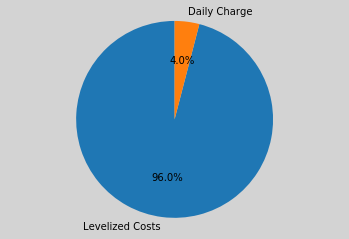

Total roof area of the  building: 599 m2
Total roof area used 438 m2
Percentage: 73.2%
succes
[[91.72666968428456, 138.9835948439295, 172.10333139376087, 32.311056343642804, 2.885740108671145, 7.922275408508151, 0.6540804197573885, 0.7059269657798142, 0.7248519305408936, 3288.08, 317.656, 0.0, 0.0, 317.656, {'Levelized Costs': 3155.025, 'Energy Charge': 0.013000000000033651, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60158636638, 61845.7, 438.236]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (114.82099796311095, 230.35964416734953, 188.05477242934717, 33.78033971121748, 19.21822045114902, 11.681390698268395, 0.3865675881182148, 0.4868711107688955, 0.4463957768590672)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 115
                                           a tilt of 33.8
                                           and a gcr of 0.387


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.650827407836914 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 19.2
                                           and a gcr of 0.487


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7039694786071777 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 188
                                           a tilt of 11.7
                                           and a gcr of 0.446


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.629824161529541 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 196 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 291.52, 0.0]


ERROR:ga_logger:Cost: 3663.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0103 /kWh
Total Cost of the system: $ 3,664 per year


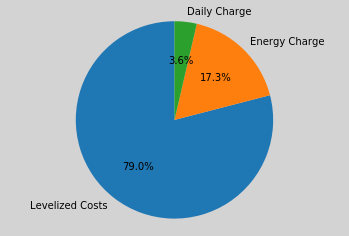

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[114.82099796311095, 230.35964416734953, 188.05477242934717, 33.78033971121748, 19.21822045114902, 11.681390698268395, 0.3865675881182148, 0.4868711107688955, 0.4463957768590672, 3663.64, 291.52, 0.0, 291.52, 0.0, {'Levelized Costs': 2895.4359999999997, 'Energy Charge': 635.1620000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 56776.580180847974, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (191.80402305550012, 111.6328261582592, 94.29591696396662, 2.2337133187459424, 40.46880895867536, 31.23605575750823, 0.8174439301512231, 0.29401471999101575, 0.7984187282324895)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 192
                                           a tilt of 2.2
                                           and a gcr of 0.817


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3826775550842285 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 112
                                           a tilt of 40.5
                                           and a gcr of 0.294


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.620800018310547 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 94
                                           a tilt of 31.2
                                           and a gcr of 0.798


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5687813758850098 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 191 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [330.113, 0.0, 0.0]


ERROR:ga_logger:Cost: 3411.81


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,412 per year


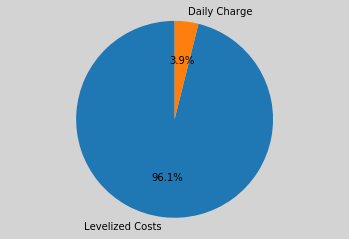

Total roof area of the  building: 599 m2
Total roof area used 404 m2
Percentage: 67.4%
succes
[[191.80402305550012, 111.6328261582592, 94.29591696396662, 2.2337133187459424, 40.46880895867536, 31.23605575750823, 0.8174439301512231, 0.29401471999101575, 0.7984187282324895, 3411.81, 330.113, 330.113, 0.0, 0.0, {'Levelized Costs': 3278.759, 'Energy Charge': 0.009000000000014552, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60157473258, 61845.7, 403.836]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (204.2735838161021, 121.00294838351806, 220.35392799151666, 31.468651098403516, 28.260554678005406, 51.47679945402022, 0.5298240762513611, 0.3697589993733012, 0.843667985739142)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 204
                                           a tilt of 31.5
                                           and a gcr of 0.530


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5430541038513184 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 121
                                           a tilt of 28.3
                                           and a gcr of 0.370


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6180500984191895 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 51.5
                                           and a gcr of 0.844


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5991098880767822 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 198 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [302.993, 0.0, 0.0]


ERROR:ga_logger:Cost: 3142.44


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,142 per year


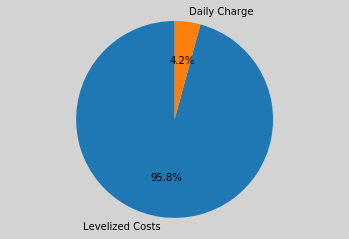

Total roof area of the  building: 599 m2
Total roof area used 572 m2
Percentage: 95.5%
succes
[[204.2735838161021, 121.00294838351806, 220.35392799151666, 31.468651098403516, 28.260554678005406, 51.47679945402022, 0.5298240762513611, 0.3697589993733012, 0.843667985739142, 3142.44, 302.993, 302.993, 0.0, 0.0, {'Levelized Costs': 3009.3840000000005, 'Energy Charge': 0.013999999999896318, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602121473596, 61845.7, 571.875]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (223.98932597823233, 108.85601449020037, 207.97041660146306, 53.94323960374728, 18.14548215798611, 46.15128799485811, 0.3957848010210975, 0.6905613911219676, 0.3313148630745753)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 224
                                           a tilt of 53.9
                                           and a gcr of 0.396


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.493861436843872 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 109
                                           a tilt of 18.1
                                           and a gcr of 0.691


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6301724910736084 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 208
                                           a tilt of 46.2
                                           and a gcr of 0.331


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.552128791809082 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 212 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 252.763, 77.1088]


ERROR:ga_logger:Cost: 3409.41


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,409 per year


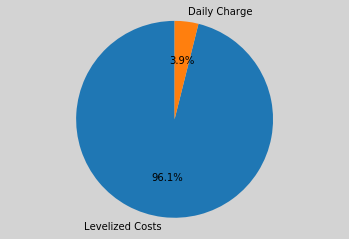

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[223.98932597823233, 108.85601449020037, 207.97041660146306, 53.94323960374728, 18.14548215798611, 46.15128799485811, 0.3957848010210975, 0.6905613911219676, 0.3313148630745753, 3409.41, 329.8718, 0.0, 252.763, 77.1088, {'Levelized Costs': 3276.348, 'Energy Charge': 0.019999999999924967, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60212979974, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (242.72965772787015, 105.564087642123, 130.3063221231051, 36.64004212165611, 40.610227573657625, 51.77028623738751, 0.8501509428405174, 0.8509857496859685, 0.7420420085527646)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 243
                                           a tilt of 36.6
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.546562433242798 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 106
                                           a tilt of 40.6
                                           and a gcr of 0.851


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5666823387145996 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 130
                                           a tilt of 51.8
                                           and a gcr of 0.742


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5747861862182617 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 209 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 377.563]


ERROR:ga_logger:Cost: 3883.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,883 per year


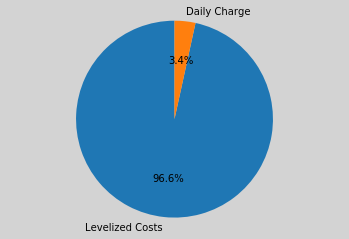

Total roof area of the  building: 599 m2
Total roof area used 509 m2
Percentage: 85.0%
succes
[[242.72965772787015, 105.564087642123, 130.3063221231051, 36.64004212165611, 40.610227573657625, 51.77028623738751, 0.8501509428405174, 0.8509857496859685, 0.7420420085527646, 3883.09, 377.563, 0.0, 0.0, 377.563, {'Levelized Costs': 3750.024, 'Energy Charge': 0.0240000000005125, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60353065007, 61845.7, 508.816]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (239.8113736832971, 113.77649494336298, 173.24888809174746, 55.610957737329564, 2.9199962085396844, 6.037931961289327, 0.3827801614370697, 0.6417860459520532, 0.4193378232376872)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 55.6
                                           and a gcr of 0.383


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.764418840408325 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 114
                                           a tilt of 2.9
                                           and a gcr of 0.642


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4122588634490967 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 173
                                           a tilt of 6.0
                                           and a gcr of 0.419


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.661320447921753 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 198 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 222.093, 105.97]


ERROR:ga_logger:Cost: 3391.44


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,391 per year


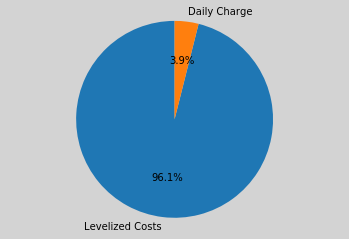

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[239.8113736832971, 113.77649494336298, 173.24888809174746, 55.610957737329564, 2.9199962085396844, 6.037931961289327, 0.3827801614370697, 0.6417860459520532, 0.4193378232376872, 3391.44, 328.063, 0.0, 222.093, 105.97, {'Levelized Costs': 3258.384, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60225088821, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (152.29348615718578, 195.41418201774636, 101.07861155182484, 51.88347745193883, 24.726021043160646, 49.49223098210712, 0.8750575972722245, 0.48588088800815193, 0.24062770558448454)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 152
                                           a tilt of 51.9
                                           and a gcr of 0.875


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5379629135131836 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 24.7
                                           and a gcr of 0.486


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.690755605697632 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 101
                                           a tilt of 49.5
                                           and a gcr of 0.241


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5968360900878906 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 196 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [27.5258, 275.643, 0.0]


ERROR:ga_logger:Cost: 3144.19


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,144 per year


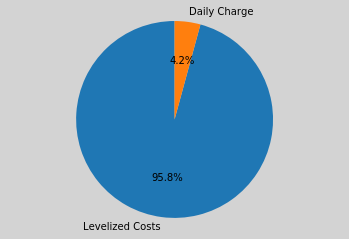

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[152.29348615718578, 195.41418201774636, 101.07861155182484, 51.88347745193883, 24.726021043160646, 49.49223098210712, 0.8750575972722245, 0.48588088800815193, 0.24062770558448454, 3144.19, 303.1688, 27.5258, 275.643, 0.0, {'Levelized Costs': 3011.133, 'Energy Charge': 0.015000000000384262, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60021570948, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (134.1264479163664, 132.55817683348914, 235.36419818869336, 31.708235064500876, 47.78947372454711, 46.64017315916969, 0.40333588353452, 0.5981193153156736, 0.657530386526795)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 134
                                           a tilt of 31.7
                                           and a gcr of 0.403


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5950846672058105 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 133
                                           a tilt of 47.8
                                           and a gcr of 0.598


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.710801601409912 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 46.6
                                           and a gcr of 0.658


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.528907299041748 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 204 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [32.3006, 310.231, 0.0]


ERROR:ga_logger:Cost: 3535.15


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,535 per year


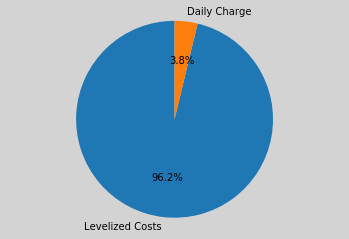

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[134.1264479163664, 132.55817683348914, 235.36419818869336, 31.708235064500876, 47.78947372454711, 46.64017315916969, 0.40333588353452, 0.5981193153156736, 0.657530386526795, 3535.15, 342.5316, 32.3006, 310.231, 0.0, {'Levelized Costs': 3402.1, 'Energy Charge': 0.008000000000151886, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60299314993, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (264.1213190001369, 123.82468030178322, 137.20337792282578, 20.527160276323446, 10.076603019203414, 26.692433243812996, 0.7226773496728423, 0.7001987193767314, 0.5733545100226753)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 20.5
                                           and a gcr of 0.723


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.577486038208008 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 124
                                           a tilt of 10.1
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.579904079437256 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 137
                                           a tilt of 26.7
                                           and a gcr of 0.573


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.5419816970825195 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 201 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 313.651]


ERROR:ga_logger:Cost: 3248.3


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,248 per year


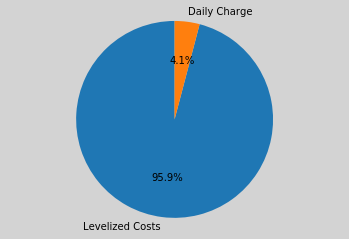

Total roof area of the  building: 599 m2
Total roof area used 547 m2
Percentage: 91.4%
succes
[[264.1213190001369, 123.82468030178322, 137.20337792282578, 20.527160276323446, 10.076603019203414, 26.692433243812996, 0.7226773496728423, 0.7001987193767314, 0.5733545100226753, 3248.3, 313.651, 0.0, 0.0, 313.651, {'Levelized Costs': 3115.2490000000003, 'Energy Charge': 0.009000000000241926, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59891584006, 61845.7, 547.045]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (153.8611899103395, 212.38977659736435, 117.65092032359662, 46.50955374214247, 38.98171556760037, 39.66383630691871, 0.340156674486023, 0.6071280017792098, 0.6007073959288155)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 154
                                           a tilt of 46.5
                                           and a gcr of 0.340


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.578087329864502 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 212
                                           a tilt of 39.0
                                           and a gcr of 0.607


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.546381950378418 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 118
                                           a tilt of 39.7
                                           and a gcr of 0.601


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.589590072631836 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 208 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [60.8919, 254.842, 0.0]


ERROR:ga_logger:Cost: 3268.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,269 per year


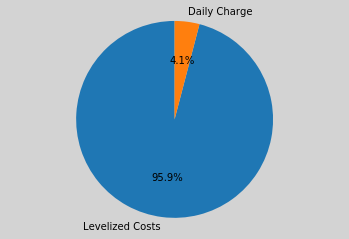

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[153.8611899103395, 212.38977659736435, 117.65092032359662, 46.50955374214247, 38.98171556760037, 39.66383630691871, 0.340156674486023, 0.6071280017792098, 0.6007073959288155, 3268.99, 315.7339, 60.8919, 254.842, 0.0, {'Levelized Costs': 3135.937, 'Energy Charge': 0.011000000000080945, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60145541402, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (244.69538060438416, 193.46809712722148, 107.94799590418098, 9.350824547455302, 54.04875259318627, 5.2814333627725425, 0.4063580813973815, 0.2619081083291199, 0.8350591669596124)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 9.4
                                           and a gcr of 0.406


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1492300033569336 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 193
                                           a tilt of 54.0
                                           and a gcr of 0.262


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.840975761413574 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 108
                                           a tilt of 5.3
                                           and a gcr of 0.835


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7944817543029785 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 302 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 113s


ERROR:ga_logger:panel relevance: [0.0, 79.177, 247.556]


ERROR:ga_logger:Cost: 3378.24


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,378 per year


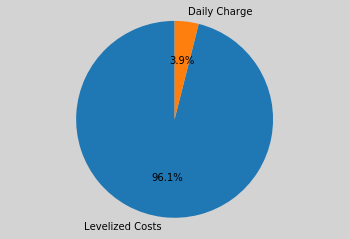

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[244.69538060438416, 193.46809712722148, 107.94799590418098, 9.350824547455302, 54.04875259318627, 5.2814333627725425, 0.4063580813973815, 0.2619081083291199, 0.8350591669596124, 3378.24, 326.733, 0.0, 79.177, 247.556, {'Levelized Costs': 3245.1779999999994, 'Energy Charge': 0.020000000000266027, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60320468584, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (199.14103168692807, 154.9668463262139, 215.0895575486224, 2.549969966440743, 12.062118440094249, 20.10716624175919, 0.45323437827534524, 0.7179176332227353, 0.5899120242884863)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 199
                                           a tilt of 2.5
                                           and a gcr of 0.453


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.027256488800049 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 12.1
                                           and a gcr of 0.718


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.834657907485962 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 20.1
                                           and a gcr of 0.590


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5962295532226562 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 291 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 310.925]


ERROR:ga_logger:Cost: 3221.23


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,221 per year


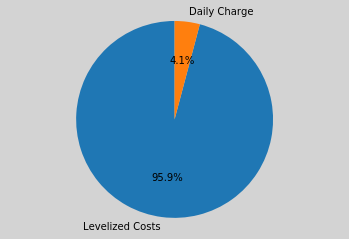

Total roof area of the  building: 599 m2
Total roof area used 527 m2
Percentage: 88.0%
succes
[[199.14103168692807, 154.9668463262139, 215.0895575486224, 2.549969966440743, 12.062118440094249, 20.10716624175919, 0.45323437827534524, 0.7179176332227353, 0.5899120242884863, 3221.23, 310.925, 0.0, 0.0, 310.925, {'Levelized Costs': 3088.17, 'Energy Charge': 0.01800000000014279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60390217964, 61845.7, 527.071]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (187.8479564987341, 110.01514683385601, 259.89180730230083, 51.17214102279877, 44.723775408682755, 46.243670547234174, 0.7907839280812454, 0.24072032280941227, 0.6347965539662423)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 188
                                           a tilt of 51.2
                                           and a gcr of 0.791


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1814558506011963 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 44.7
                                           and a gcr of 0.241


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9797630310058594 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 46.2
                                           and a gcr of 0.635


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8824682235717773 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 295 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [331.076, 0.0, 0.0]


ERROR:ga_logger:Cost: 3421.37


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,421 per year


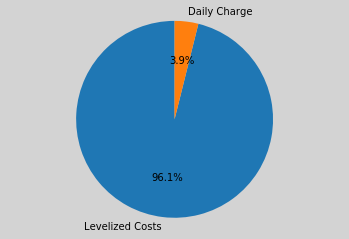

Total roof area of the  building: 599 m2
Total roof area used 419 m2
Percentage: 69.9%
succes
[[187.8479564987341, 110.01514683385601, 259.89180730230083, 51.17214102279877, 44.723775408682755, 46.243670547234174, 0.7907839280812454, 0.24072032280941227, 0.6347965539662423, 3421.37, 331.076, 331.076, 0.0, 0.0, {'Levelized Costs': 3288.3179999999998, 'Energy Charge': 0.010000000000104592, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599852679064, 61845.7, 418.667]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (254.88887064034284, 145.868348632347, 192.61162837847058, 6.260868743041459, 18.775002261269286, 2.3737434368911785, 0.7424797455823047, 0.8349083773730801, 0.8546795969402812)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 6.3
                                           and a gcr of 0.742


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2425155639648438 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 146
                                           a tilt of 18.8
                                           and a gcr of 0.835


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.088517189025879 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 193
                                           a tilt of 2.4
                                           and a gcr of 0.855


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.794086217880249 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 276 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [0.0, 323.611, 0.0]


ERROR:ga_logger:Cost: 3347.23


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,347 per year


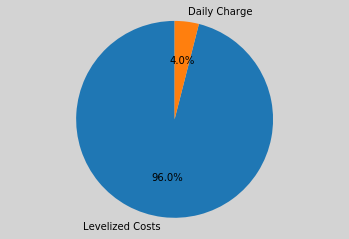

Total roof area of the  building: 599 m2
Total roof area used 388 m2
Percentage: 64.7%
succes
[[254.88887064034284, 145.868348632347, 192.61162837847058, 6.260868743041459, 18.775002261269286, 2.3737434368911785, 0.7424797455823047, 0.8349083773730801, 0.8546795969402812, 3347.23, 323.611, 0.0, 323.611, 0.0, {'Levelized Costs': 3214.1650000000004, 'Energy Charge': 0.022999999999797183, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6015965639, 61845.7, 387.601]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (261.35472657251296, 238.42904475946446, 189.46889159195823, 38.787436063638104, 4.503076195070761, 32.62321824041143, 0.21773359767848113, 0.24007002267825764, 0.2695312578495151)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 261
                                           a tilt of 38.8
                                           and a gcr of 0.218


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3178725242614746 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 238
                                           a tilt of 4.5
                                           and a gcr of 0.240


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0523476600646973 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 189
                                           a tilt of 32.6
                                           and a gcr of 0.270


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0940425395965576 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 279 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 161.385]


ERROR:ga_logger:Cost: 5192.23


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0559 /kWh
Total Cost of the system: $ 5,192 per year


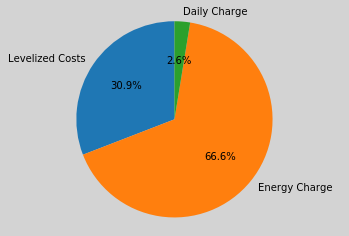

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[261.35472657251296, 238.42904475946446, 189.46889159195823, 38.787436063638104, 4.503076195070761, 32.62321824041143, 0.21773359767848113, 0.24007002267825764, 0.2695312578495151, 5192.23, 161.385, 0.0, 0.0, 161.385, {'Levelized Costs': 1602.9079999999994, 'Energy Charge': 3456.28, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 34261.68116393921, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (165.92935636293342, 226.04243689171963, 179.47813611630136, 24.921801905028783, 50.74576540763256, 48.13195258562713, 0.23779509114140326, 0.7989592049756202, 0.7863761593152825)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 166
                                           a tilt of 24.9
                                           and a gcr of 0.238


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.949037551879883 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 226
                                           a tilt of 50.7
                                           and a gcr of 0.799


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.798365592956543 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 179
                                           a tilt of 48.1
                                           and a gcr of 0.786


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.820565700531006 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 284 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 119s


ERROR:ga_logger:panel relevance: [66.1612, 0.0, 252.06]


ERROR:ga_logger:Cost: 3293.7


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 46,557 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,294 per year


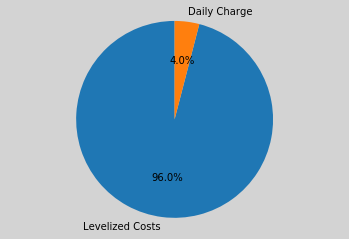

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[165.92935636293342, 226.04243689171963, 179.47813611630136, 24.921801905028783, 50.74576540763256, 48.13195258562713, 0.23779509114140326, 0.7989592049756202, 0.7863761593152825, 3293.7, 318.2212, 66.1612, 0.0, 252.06, {'Levelized Costs': 3160.647, 'Energy Charge': 0.010999999999967258, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6024183601, 46556.9, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (215.73099277179395, 135.38171508412933, 216.84632504765466, 33.934784898773614, 13.684182355869801, 15.090848095506507, 0.7383684668948385, 0.6097671444454495, 0.34816251096814876)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 216
                                           a tilt of 33.9
                                           and a gcr of 0.738


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9993343353271484 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 13.7
                                           and a gcr of 0.610


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9015097618103027 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 217
                                           a tilt of 15.1
                                           and a gcr of 0.348


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9481992721557617 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 264 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [0.0, 249.099, 66.2367]


ERROR:ga_logger:Cost: 3265.04


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,265 per year


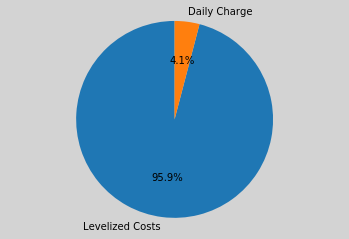

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[215.73099277179395, 135.38171508412933, 216.84632504765466, 33.934784898773614, 13.684182355869801, 15.090848095506507, 0.7383684668948385, 0.6097671444454495, 0.34816251096814876, 3265.04, 315.3357, 0.0, 249.099, 66.2367, {'Levelized Costs': 3131.984, 'Energy Charge': 0.013999999999896318, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6015717348, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (199.0365663752282, 95.86039880870284, 149.6365325769645, 26.21762074792319, 42.576888495745145, 21.518278638519163, 0.6137873164348311, 0.48594785080234904, 0.6468164053440586)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 199
                                           a tilt of 26.2
                                           and a gcr of 0.614


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0291504859924316 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 96
                                           a tilt of 42.6
                                           and a gcr of 0.486


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.954545497894287 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 21.5
                                           and a gcr of 0.647


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9218192100524902 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 244 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [303.397, 0.0, 0.0]


ERROR:ga_logger:Cost: 3146.45


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,146 per year


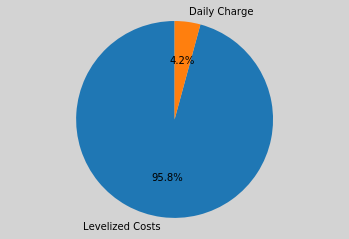

Total roof area of the  building: 599 m2
Total roof area used 494 m2
Percentage: 82.6%
succes
[[199.0365663752282, 95.86039880870284, 149.6365325769645, 26.21762074792319, 42.576888495745145, 21.518278638519163, 0.6137873164348311, 0.48594785080234904, 0.6468164053440586, 3146.45, 303.397, 303.397, 0.0, 0.0, {'Levelized Costs': 3013.3999999999996, 'Energy Charge': 0.008000000000265572, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60077896904, 61845.7, 494.303]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (141.08096506250658, 229.15507582954515, 156.94391845698902, 7.583119124919394, 16.15126717442495, 22.869554825125796, 0.7059014049579684, 0.38100585390266273, 0.28471660529760423)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 141
                                           a tilt of 7.6
                                           and a gcr of 0.706


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1113040447235107 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 229
                                           a tilt of 16.2
                                           and a gcr of 0.381


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.694619655609131 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 157
                                           a tilt of 22.9
                                           and a gcr of 0.285


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9551103115081787 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 278 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [243.208, 0.0, 72.3825]


ERROR:ga_logger:Cost: 3267.56


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,268 per year


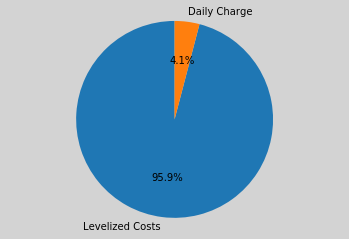

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[141.08096506250658, 229.15507582954515, 156.94391845698902, 7.583119124919394, 16.15126717442495, 22.869554825125796, 0.7059014049579684, 0.38100585390266273, 0.28471660529760423, 3267.56, 315.5905, 243.208, 0.0, 72.3825, {'Levelized Costs': 3134.506, 'Energy Charge': 0.012000000000284672, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60203539995, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (130.4304067911762, 136.2905645103662, 216.40520597005803, 22.581183293715604, 40.26699397908032, 2.3586588650911864, 0.33517263858517615, 0.30644703168703974, 0.5853647706778873)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 22.6
                                           and a gcr of 0.335


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.974519729614258 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 136
                                           a tilt of 40.3
                                           and a gcr of 0.306


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7998623847961426 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 216
                                           a tilt of 2.4
                                           and a gcr of 0.585


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6566505432128906 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 281 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 109s


ERROR:ga_logger:panel relevance: [28.6517, 0.0, 300.455]


ERROR:ga_logger:Cost: 3401.81


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,402 per year


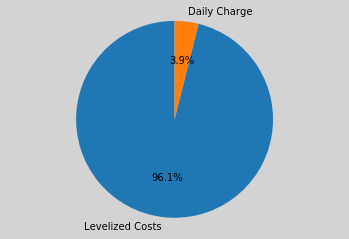

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[130.4304067911762, 136.2905645103662, 216.40520597005803, 22.581183293715604, 40.26699397908032, 2.3586588650911864, 0.33517263858517615, 0.30644703168703974, 0.5853647706778873, 3401.81, 329.1067, 28.6517, 0.0, 300.455, {'Levelized Costs': 3268.753, 'Energy Charge': 0.015000000000100044, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60202464712, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (242.02935465209302, 148.66024174759755, 230.08970516210655, 30.561987506663993, 13.48021198586544, 11.586961639913557, 0.791553238669851, 0.2678535803316655, 0.29277385279491697)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 242
                                           a tilt of 30.6
                                           and a gcr of 0.792


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9875075817108154 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 149
                                           a tilt of 13.5
                                           and a gcr of 0.268


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.867830991744995 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 11.6
                                           and a gcr of 0.293


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.284298896789551 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 272 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [286.364, 63.4779, 0.0]


ERROR:ga_logger:Cost: 3607.75


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,608 per year


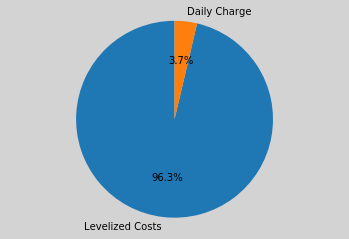

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[242.02935465209302, 148.66024174759755, 230.08970516210655, 30.561987506663993, 13.48021198586544, 11.586961639913557, 0.791553238669851, 0.2678535803316655, 0.29277385279491697, 3607.75, 349.84189999999995, 286.364, 63.4779, 0.0, {'Levelized Costs': 3474.698, 'Energy Charge': 0.009999999999990905, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60294061839, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (238.7556668190582, 230.3162956455331, 160.1379247329589, 13.046523663326067, 2.5457761888704455, 29.297670835866377, 0.6464677846749933, 0.4350196766540987, 0.6079210703511545)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 239
                                           a tilt of 13.0
                                           and a gcr of 0.646


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0887866020202637 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 2.5
                                           and a gcr of 0.435


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.684088706970215 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 29.3
                                           and a gcr of 0.608


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8690619468688965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 286 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 303.769]


ERROR:ga_logger:Cost: 3150.16


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,150 per year


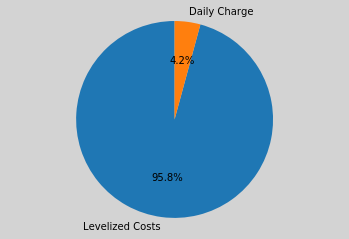

Total roof area of the  building: 599 m2
Total roof area used 500 m2
Percentage: 83.5%
succes
[[238.7556668190582, 230.3162956455331, 160.1379247329589, 13.046523663326067, 2.5457761888704455, 29.297670835866377, 0.6464677846749933, 0.4350196766540987, 0.6079210703511545, 3150.16, 303.769, 0.0, 0.0, 303.769, {'Levelized Costs': 3017.096, 'Energy Charge': 0.02200000000016189, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60391960005, 61845.7, 499.686]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (144.06344456997803, 188.26263822712235, 101.23139197476262, 27.900686260138087, 34.78353886140009, 28.47970573982461, 0.4990889833823545, 0.6762669270996395, 0.852459086600736)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 144
                                           a tilt of 27.9
                                           and a gcr of 0.499


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0901882648468018 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 188
                                           a tilt of 34.8
                                           and a gcr of 0.676


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.026454448699951 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 101
                                           a tilt of 28.5
                                           and a gcr of 0.852


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9804046154022217 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 257 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 95s


ERROR:ga_logger:panel relevance: [0.0, 304.946, 0.0]


ERROR:ga_logger:Cost: 3161.84


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,162 per year


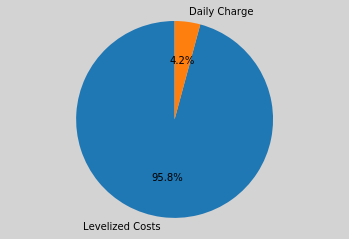

Total roof area of the  building: 599 m2
Total roof area used 451 m2
Percentage: 75.3%
succes
[[144.06344456997803, 188.26263822712235, 101.23139197476262, 27.900686260138087, 34.78353886140009, 28.47970573982461, 0.4990889833823545, 0.6762669270996395, 0.852459086600736, 3161.84, 304.946, 0.0, 304.946, 0.0, {'Levelized Costs': 3028.78, 'Energy Charge': 0.018000000000199634, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59966660732, 61845.7, 450.926]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (112.05953866501565, 145.16361939653052, 139.89118226705648, 28.172023734405908, 2.5739155073300912, 36.244218681634, 0.5630724661119679, 0.21137464581797927, 0.5997913996224973)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 112
                                           a tilt of 28.2
                                           and a gcr of 0.563


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1347126960754395 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 2.6
                                           and a gcr of 0.211


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.779975175857544 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 36.2
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9073398113250732 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 273 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 320.57]


ERROR:ga_logger:Cost: 3317.02


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,317 per year


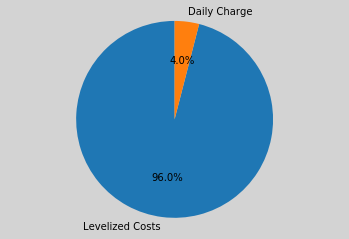

Total roof area of the  building: 599 m2
Total roof area used 534 m2
Percentage: 89.3%
succes
[[112.05953866501565, 145.16361939653052, 139.89118226705648, 28.172023734405908, 2.5739155073300912, 36.244218681634, 0.5630724661119679, 0.21137464581797927, 0.5997913996224973, 3317.02, 320.57, 0.0, 0.0, 320.57, {'Levelized Costs': 3183.964, 'Energy Charge': 0.014000000000237378, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60278867014, 61845.7, 534.469]]
The maximum power used is 16 kW


The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (163.54882753423817, 147.00404655457834, 225.45624813835278, 24.54214964273998, 52.74997466145709, 42.82127560012155, 0.8552557574526958, 0.7954612067063263, 0.5640570472724294)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 164
                                           a tilt of 24.5
                                           and a gcr of 0.855


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.032855987548828 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 147
                                           a tilt of 52.7
                                           and a gcr of 0.795


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.937047243118286 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 42.8
                                           and a gcr of 0.564


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1858410835266113 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 260 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 110s


ERROR:ga_logger:panel relevance: [319.416, 0.0, 0.0]


ERROR:ga_logger:Cost: 3305.56


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,306 per year


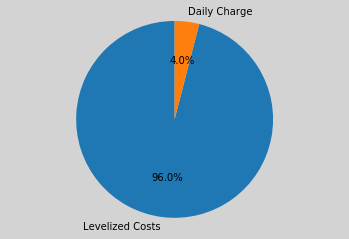

Total roof area of the  building: 599 m2
Total roof area used 373 m2
Percentage: 62.4%
succes
[[163.54882753423817, 147.00404655457834, 225.45624813835278, 24.54214964273998, 52.74997466145709, 42.82127560012155, 0.8552557574526958, 0.7954612067063263, 0.5640570472724294, 3305.56, 319.416, 319.416, 0.0, 0.0, {'Levelized Costs': 3172.504, 'Energy Charge': 0.014000000000237378, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.604341807804, 61845.7, 373.474]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (221.9457954650393, 212.68606549593153, 99.35022925537119, 20.029982508605435, 1.097561048410092, 55.649195275374346, 0.7697062429365702, 0.26109796664209417, 0.6151593961698156)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 222
                                           a tilt of 20.0
                                           and a gcr of 0.770


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0321857929229736 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 213
                                           a tilt of 1.1
                                           and a gcr of 0.261


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.3101460933685303 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 99
                                           a tilt of 55.6
                                           and a gcr of 0.615


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.852743625640869 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 234 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [324.499, 0.0, 0.0]


ERROR:ga_logger:Cost: 3356.05


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,356 per year


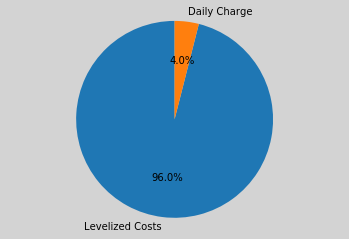

Total roof area of the  building: 599 m2
Total roof area used 422 m2
Percentage: 70.4%
succes
[[221.9457954650393, 212.68606549593153, 99.35022925537119, 20.029982508605435, 1.097561048410092, 55.649195275374346, 0.7697062429365702, 0.26109796664209417, 0.6151593961698156, 3356.05, 324.499, 324.499, 0.0, 0.0, {'Levelized Costs': 3223.003, 'Energy Charge': 0.005000000000165983, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60168507058, 61845.7, 421.588]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (167.745531837948, 96.7802634594716, 177.9693213487031, 2.5130190854921786, 13.17126750780048, 41.1905906743877, 0.6658166908623934, 0.6427660057053133, 0.5313334427320119)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 168
                                           a tilt of 2.5
                                           and a gcr of 0.666


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8292996883392334 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 97
                                           a tilt of 13.2
                                           and a gcr of 0.643


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.677338123321533 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 41.2
                                           and a gcr of 0.531


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.731388568878174 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 226 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 111s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 301.171]


ERROR:ga_logger:Cost: 3124.34


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,124 per year


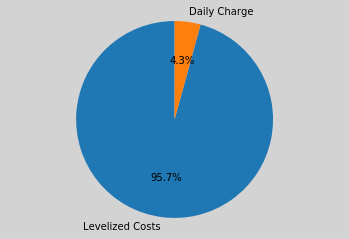

Total roof area of the  building: 599 m2
Total roof area used 567 m2
Percentage: 94.7%
succes
[[167.745531837948, 96.7802634594716, 177.9693213487031, 2.5130190854921786, 13.17126750780048, 41.1905906743877, 0.6658166908623934, 0.6427660057053133, 0.5313334427320119, 3124.34, 301.171, 0.0, 0.0, 301.171, {'Levelized Costs': 2991.289, 'Energy Charge': 0.009000000000128239, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60120658896, 61845.7, 566.82]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (212.15346242625128, 167.90617678075859, 262.9830596357814, 28.419185269390148, 52.02337558378723, 16.51938839788855, 0.5063623480677792, 0.35911284019317624, 0.329935073206331)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 212
                                           a tilt of 28.4
                                           and a gcr of 0.506


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0865068435668945 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 168
                                           a tilt of 52.0
                                           and a gcr of 0.359


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8921163082122803 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 263
                                           a tilt of 16.5
                                           and a gcr of 0.330


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.974456548690796 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 237 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [303.19, 0.0, 0.0]


ERROR:ga_logger:Cost: 3217.07


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0012 /kWh
Total Cost of the system: $ 3,217 per year


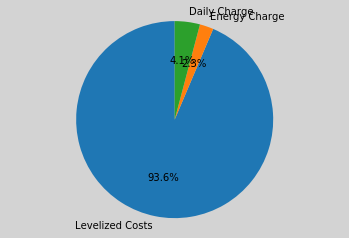

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[212.15346242625128, 167.90617678075859, 262.9830596357814, 28.419185269390148, 52.02337558378723, 16.51938839788855, 0.5063623480677792, 0.35911284019317624, 0.329935073206331, 3217.07, 303.19, 303.19, 0.0, 0.0, {'Levelized Costs': 3011.347, 'Energy Charge': 72.68100000000015, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61265.65939538436, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (100.04719838183709, 190.44153703762305, 172.84901102929385, 27.774808632283225, 51.91753304738349, 24.56362534206534, 0.20157220004919663, 0.7137539202835697, 0.871718175924937)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 27.8
                                           and a gcr of 0.202


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.050365924835205 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 51.9
                                           and a gcr of 0.714


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7830429077148438 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 173
                                           a tilt of 24.6
                                           and a gcr of 0.872


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7662580013275146 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 246 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 112s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 317.861]


ERROR:ga_logger:Cost: 3290.11


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,290 per year


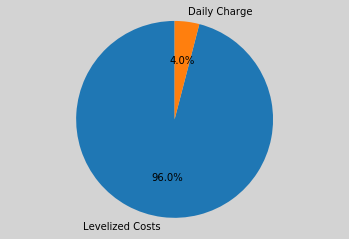

Total roof area of the  building: 599 m2
Total roof area used 365 m2
Percentage: 60.9%
succes
[[100.04719838183709, 190.44153703762305, 172.84901102929385, 27.774808632283225, 51.91753304738349, 24.56362534206534, 0.20157220004919663, 0.7137539202835697, 0.871718175924937, 3290.11, 317.861, 0.0, 0.0, 317.861, {'Levelized Costs': 3157.055, 'Energy Charge': 0.013000000000374712, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59914240815, 61845.7, 364.637]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (241.37924197553107, 209.48307428043518, 127.65801178155961, 11.548556607277717, 53.41990638632529, 12.622183833542188, 0.23903506377974584, 0.6438543920959021, 0.33322937229470184)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 241
                                           a tilt of 11.5
                                           and a gcr of 0.239


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5199928283691406 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 209
                                           a tilt of 53.4
                                           and a gcr of 0.644


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8853347301483154 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 128
                                           a tilt of 12.6
                                           and a gcr of 0.333


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.887662410736084 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 218 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 121s


ERROR:ga_logger:panel relevance: [0.0, 285.812, 51.6021]


ERROR:ga_logger:Cost: 3484.32


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,484 per year


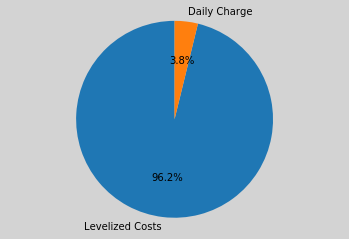

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[241.37924197553107, 209.48307428043518, 127.65801178155961, 11.548556607277717, 53.41990638632529, 12.622183833542188, 0.23903506377974584, 0.6438543920959021, 0.33322937229470184, 3484.32, 337.4141, 0.0, 285.812, 51.6021, {'Levelized Costs': 3351.2670000000003, 'Energy Charge': 0.011000000000194632, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60172898703, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (257.6776312467311, 150.4187525606178, 181.28772440546481, 16.55560076475077, 42.40437658142672, 13.477972524023288, 0.39959197348211983, 0.535075824732636, 0.6680565431689713)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 258
                                           a tilt of 16.6
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.172985076904297 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 42.4
                                           and a gcr of 0.535


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.988030195236206 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 13.5
                                           and a gcr of 0.668


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.023555040359497 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 222 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 308.131]


ERROR:ga_logger:Cost: 3193.48


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,193 per year


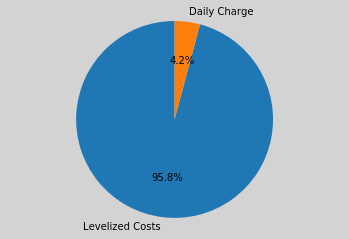

Total roof area of the  building: 599 m2
Total roof area used 461 m2
Percentage: 77.0%
succes
[[257.6776312467311, 150.4187525606178, 181.28772440546481, 16.55560076475077, 42.40437658142672, 13.477972524023288, 0.39959197348211983, 0.535075824732636, 0.6680565431689713, 3193.48, 308.131, 0.0, 0.0, 308.131, {'Levelized Costs': 3060.43, 'Energy Charge': 0.008000000000265572, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60115780823, 61845.7, 461.235]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (236.6981070293179, 177.8515637169249, 253.57819648854695, 20.81678665129028, 6.38433089612873, 41.93793705984662, 0.5843567808542299, 0.8704937760425642, 0.2914510185139655)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 237
                                           a tilt of 20.8
                                           and a gcr of 0.584


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2339553833007812 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 6.4
                                           and a gcr of 0.870


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9198787212371826 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 254
                                           a tilt of 41.9
                                           and a gcr of 0.291


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9089126586914062 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 236 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 117s


ERROR:ga_logger:panel relevance: [0.0, 323.23, 0.0]


ERROR:ga_logger:Cost: 3343.44


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,343 per year


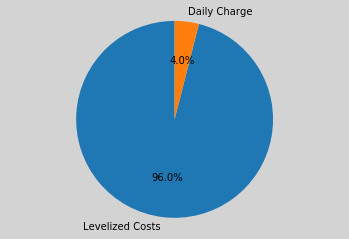

Total roof area of the  building: 599 m2
Total roof area used 371 m2
Percentage: 62.0%
succes
[[236.6981070293179, 177.8515637169249, 253.57819648854695, 20.81678665129028, 6.38433089612873, 41.93793705984662, 0.5843567808542299, 0.8704937760425642, 0.2914510185139655, 3343.44, 323.23, 0.0, 323.23, 0.0, {'Levelized Costs': 3210.381, 'Energy Charge': 0.01700000000005275, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600543907065, 61845.7, 371.318]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (187.5516729440471, 151.67163438500347, 196.571780594975, 28.680144654866208, 41.83494645960527, 31.273088555915578, 0.41076677855404553, 0.6117567603422691, 0.42099780650789453)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 188
                                           a tilt of 28.7
                                           and a gcr of 0.411


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1281723976135254 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 152
                                           a tilt of 41.8
                                           and a gcr of 0.612


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8912768363952637 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 197
                                           a tilt of 31.3
                                           and a gcr of 0.421


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9247617721557617 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 161 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 118s


ERROR:ga_logger:panel relevance: [118.619, 189.637, 0.0]


ERROR:ga_logger:Cost: 3194.71


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,195 per year


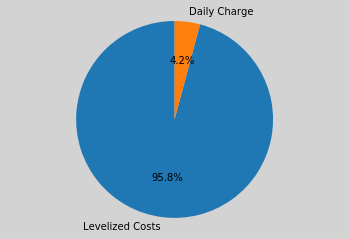

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[187.5516729440471, 151.67163438500347, 196.571780594975, 28.680144654866208, 41.83494645960527, 31.273088555915578, 0.41076677855404553, 0.6117567603422691, 0.42099780650789453, 3194.71, 308.256, 118.619, 189.637, 0.0, {'Levelized Costs': 3061.652, 'Energy Charge': 0.016000000000190084, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603906075165, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (104.3498046746907, 189.90747105694498, 242.11043190346345, 23.29987166399278, 53.58348215259251, 46.91323484094511, 0.39676631340446933, 0.7160326874095502, 0.6182033991122939)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 104
                                           a tilt of 23.3
                                           and a gcr of 0.397


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2867469787597656 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 53.6
                                           and a gcr of 0.716


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.013169288635254 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 242
                                           a tilt of 46.9
                                           and a gcr of 0.618


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0333831310272217 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 214 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 110s


ERROR:ga_logger:panel relevance: [0.0, 330.724, 0.0]


ERROR:ga_logger:Cost: 3417.88


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,418 per year


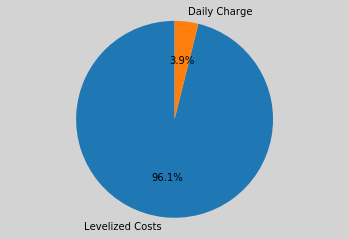

Total roof area of the  building: 599 m2
Total roof area used 462 m2
Percentage: 77.1%
succes
[[104.3498046746907, 189.90747105694498, 242.11043190346345, 23.29987166399278, 53.58348215259251, 46.91323484094511, 0.39676631340446933, 0.7160326874095502, 0.6182033991122939, 3417.88, 330.724, 0.0, 330.724, 0.0, {'Levelized Costs': 3284.827, 'Energy Charge': 0.011000000000080945, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60105854291, 61845.7, 461.885]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (106.15729076912997, 194.1609031165494, 100.76122523967254, 46.56237105997452, 25.03049306688448, 55.49010559155989, 0.7867579468617021, 0.5013792066440799, 0.30814461570865315)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 106
                                           a tilt of 46.6
                                           and a gcr of 0.787


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.309436798095703 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 194
                                           a tilt of 25.0
                                           and a gcr of 0.501


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9447875022888184 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 101
                                           a tilt of 55.5
                                           and a gcr of 0.308


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.997192621231079 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 205 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [0.0, 298.203, 0.0]


ERROR:ga_logger:Cost: 3094.87


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,095 per year


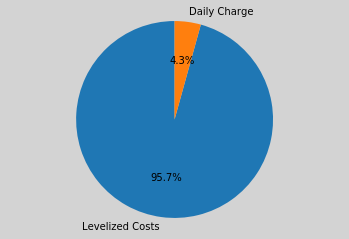

Total roof area of the  building: 599 m2
Total roof area used 595 m2
Percentage: 99.3%
succes
[[106.15729076912997, 194.1609031165494, 100.76122523967254, 46.56237105997452, 25.03049306688448, 55.49010559155989, 0.7867579468617021, 0.5013792066440799, 0.30814461570865315, 3094.87, 298.203, 0.0, 298.203, 0.0, {'Levelized Costs': 2961.814, 'Energy Charge': 0.014000000000237378, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601205808925, 61845.7, 594.766]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (91.86850430007287, 250.8009005213082, 143.13471707759174, 53.98833821809694, 25.580356343952854, 46.95789750191425, 0.8105578156920514, 0.22192886568875864, 0.8181725947754985)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 54.0
                                           and a gcr of 0.811


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.222041606903076 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 251
                                           a tilt of 25.6
                                           and a gcr of 0.222


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2193856239318848 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 143
                                           a tilt of 47.0
                                           and a gcr of 0.818


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9229540824890137 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 209 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 104s


ERROR:ga_logger:panel relevance: [0.0, 50.921, 302.163]


ERROR:ga_logger:Cost: 3639.96


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,640 per year


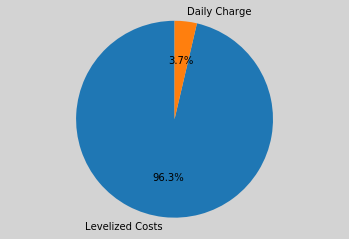

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[91.86850430007287, 250.8009005213082, 143.13471707759174, 53.98833821809694, 25.580356343952854, 46.95789750191425, 0.8105578156920514, 0.22192886568875864, 0.8181725947754985, 3639.96, 353.084, 0.0, 50.921, 302.163, {'Levelized Costs': 3506.907, 'Energy Charge': 0.010999999999967258, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600678327486, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (232.34864013774143, 112.08793411792506, 222.38959158494112, 36.100289665695186, 30.26161196601917, 5.457436429931798, 0.8818520806416126, 0.3038812995035931, 0.7195491325379617)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 232
                                           a tilt of 36.1
                                           and a gcr of 0.882


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.290963888168335 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 112
                                           a tilt of 30.3
                                           and a gcr of 0.304


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0893359184265137 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 222
                                           a tilt of 5.5
                                           and a gcr of 0.720


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.677517890930176 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 228 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 118s


ERROR:ga_logger:panel relevance: [0.0, 76.1577, 250.508]


ERROR:ga_logger:Cost: 3377.56


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,378 per year


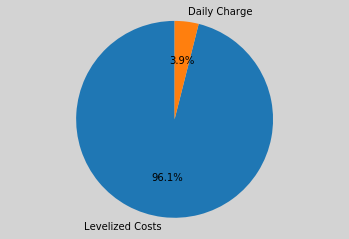

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[232.34864013774143, 112.08793411792506, 222.38959158494112, 36.100289665695186, 30.26161196601917, 5.457436429931798, 0.8818520806416126, 0.3038812995035931, 0.7195491325379617, 3377.56, 326.6657, 0.0, 76.1577, 250.508, {'Levelized Costs': 3244.4950000000003, 'Energy Charge': 0.02299999999991087, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59991918983, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (244.636008110607, 262.07554482507885, 223.168629046324, 29.26943515584885, 18.73305423771013, 51.35267664227359, 0.4629423762140686, 0.7703019370731994, 0.5363510994428791)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 29.3
                                           and a gcr of 0.463


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4017295837402344 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 262
                                           a tilt of 18.7
                                           and a gcr of 0.770


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.971625328063965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 223
                                           a tilt of 51.4
                                           and a gcr of 0.536


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.006621837615967 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 229 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 122s


ERROR:ga_logger:panel relevance: [174.772, 170.419, 0.0]


ERROR:ga_logger:Cost: 3561.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,562 per year


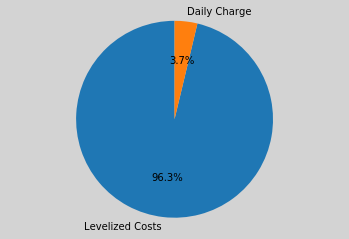

ERROR:optimizer_logger:50


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[244.636008110607, 262.07554482507885, 223.168629046324, 29.26943515584885, 18.73305423771013, 51.35267664227359, 0.4629423762140686, 0.7703019370731994, 0.5363510994428791, 3561.57, 345.19100000000003, 174.772, 170.419, 0.0, {'Levelized Costs': 3428.52, 'Energy Charge': 0.008000000000265572, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60074174202, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (204.2735838161021, 121.00294838351806, 237.0627756079188, 31.603865315464, 43.550742758255836, 54.31872603555102, 0.6141655907285211, 0.463051856720984, 0.843667985739142)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 204
                                           a tilt of 31.6
                                           and a gcr of 0.614


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.320169448852539 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 121
                                           a tilt of 43.6
                                           and a gcr of 0.463


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.087245225906372 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 237
                                           a tilt of 54.3
                                           and a gcr of 0.844


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.03794527053833 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 230 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 113s


ERROR:ga_logger:panel relevance: [307.4, 0.0, 0.0]


ERROR:ga_logger:Cost: 3186.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,186 per year


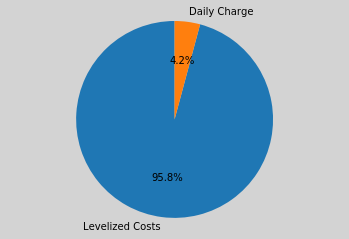

Total roof area of the  building: 599 m2
Total roof area used 501 m2
Percentage: 83.6%
succes
[[204.2735838161021, 121.00294838351806, 237.0627756079188, 31.603865315464, 43.550742758255836, 54.31872603555102, 0.6141655907285211, 0.463051856720984, 0.843667985739142, 3186.21, 307.4, 307.4, 0.0, 0.0, {'Levelized Costs': 3053.148, 'Energy Charge': 0.02000000000015234, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59855323539, 61845.7, 500.516]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (199.0365663752282, 97.33959347036799, 161.5059170539996, 26.21762074792319, 19.186311530830356, 18.732201586605242, 0.5250231205188632, 0.33988423602712986, 0.6468164053440586)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 199
                                           a tilt of 26.2
                                           and a gcr of 0.525


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.418055772781372 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 97
                                           a tilt of 19.2
                                           and a gcr of 0.340


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0348756313323975 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 162
                                           a tilt of 18.7
                                           and a gcr of 0.647


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0699942111968994 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 209 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 102s


ERROR:ga_logger:panel relevance: [300.112, 0.0, 0.0]


ERROR:ga_logger:Cost: 3113.83


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,114 per year


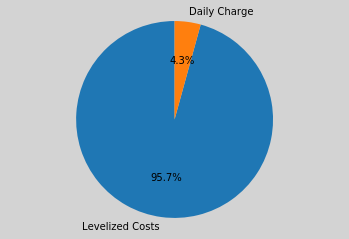

Total roof area of the  building: 599 m2
Total roof area used 572 m2
Percentage: 95.5%
succes
[[199.0365663752282, 97.33959347036799, 161.5059170539996, 26.21762074792319, 19.186311530830356, 18.732201586605242, 0.5250231205188632, 0.33988423602712986, 0.6468164053440586, 3113.83, 300.112, 300.112, 0.0, 0.0, {'Levelized Costs': 2980.7679999999996, 'Energy Charge': 0.02000000000032287, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60288336876, 61845.7, 571.616]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (164.01644362097628, 151.43263671473855, 216.00905511660744, 30.039720560540708, 51.21839750616806, 42.82127560012155, 0.8552557574526958, 0.8038449417449903, 0.5781406241484168)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 164
                                           a tilt of 30.0
                                           and a gcr of 0.855


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.408076286315918 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 151
                                           a tilt of 51.2
                                           and a gcr of 0.804


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9695658683776855 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 216
                                           a tilt of 42.8
                                           and a gcr of 0.578


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.977994918823242 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 277 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [321.847, 0.0, 0.0]


ERROR:ga_logger:Cost: 3329.7


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,330 per year


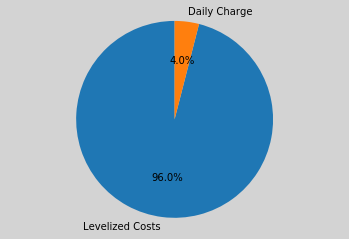

Total roof area of the  building: 599 m2
Total roof area used 376 m2
Percentage: 62.8%
succes
[[164.01644362097628, 151.43263671473855, 216.00905511660744, 30.039720560540708, 51.21839750616806, 42.82127560012155, 0.8552557574526958, 0.8038449417449903, 0.5781406241484168, 3329.7, 321.847, 321.847, 0.0, 0.0, {'Levelized Costs': 3196.6419999999994, 'Energy Charge': 0.016000000000360615, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.604923531006, 61845.7, 376.316]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (113.32238357366225, 145.16361939653052, 123.74382889814262, 27.689163226672054, 2.5739155073300912, 37.54581839757247, 0.5630724661119679, 0.26853649780109645, 0.5726602810777971)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 113
                                           a tilt of 27.7
                                           and a gcr of 0.563


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6904971599578857 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 2.6
                                           and a gcr of 0.269


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.912936210632324 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 124
                                           a tilt of 37.5
                                           and a gcr of 0.573


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0462706089019775 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 271 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [335.175, 0.939999, 0.0]


ERROR:ga_logger:Cost: 3471.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,471 per year


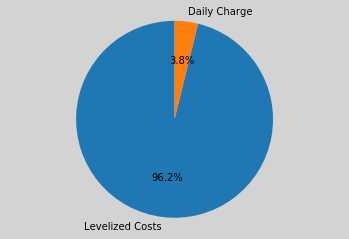

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[113.32238357366225, 145.16361939653052, 123.74382889814262, 27.689163226672054, 2.5739155073300912, 37.54581839757247, 0.5630724661119679, 0.26853649780109645, 0.5726602810777971, 3471.42, 336.114999, 335.175, 0.939999, 0.0, {'Levelized Costs': 3338.356, 'Energy Charge': 0.022000000000048203, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59941095001, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (236.7079752053328, 177.87574457307844, 170.29072044362536, 23.344435359087182, 20.780235277570277, 41.74807478025295, 0.8991387602652836, 0.8212155760733361, 0.6992494359855693)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 237
                                           a tilt of 23.3
                                           and a gcr of 0.899


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8222298622131348 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 20.8
                                           and a gcr of 0.821


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.999934673309326 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 170
                                           a tilt of 41.7
                                           and a gcr of 0.699


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9704713821411133 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 281 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [0.0, 312.26, 0.0]


ERROR:ga_logger:Cost: 3234.48


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,234 per year


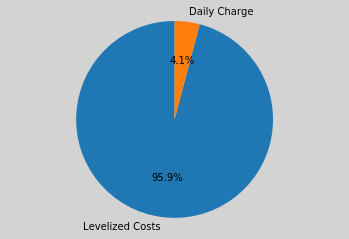

Total roof area of the  building: 599 m2
Total roof area used 380 m2
Percentage: 63.5%
succes
[[236.7079752053328, 177.87574457307844, 170.29072044362536, 23.344435359087182, 20.780235277570277, 41.74807478025295, 0.8991387602652836, 0.8212155760733361, 0.6992494359855693, 3234.48, 312.26, 0.0, 312.26, 0.0, {'Levelized Costs': 3101.416, 'Energy Charge': 0.022000000000105047, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.5993557134, 61845.7, 380.241]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (139.0772977583753, 174.91099377747818, 251.1061916881409, 20.021509098198166, 10.061656449424127, 38.09238184769198, 0.6187365432934008, 0.7493877266802563, 0.3169755730809497)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 139
                                           a tilt of 20.0
                                           and a gcr of 0.619


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.667888879776001 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 10.1
                                           and a gcr of 0.749


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.909389019012451 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 251
                                           a tilt of 38.1
                                           and a gcr of 0.317


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.958026170730591 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 264 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [313.292, 0.0, 0.0]


ERROR:ga_logger:Cost: 3244.74


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,245 per year


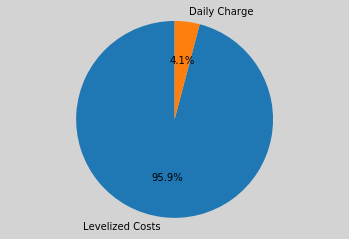

Total roof area of the  building: 599 m2
Total roof area used 506 m2
Percentage: 84.6%
succes
[[139.0772977583753, 174.91099377747818, 251.1061916881409, 20.021509098198166, 10.061656449424127, 38.09238184769198, 0.6187365432934008, 0.7493877266802563, 0.3169755730809497, 3244.74, 313.292, 313.292, 0.0, 0.0, {'Levelized Costs': 3111.692, 'Energy Charge': 0.005999999999971806, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602234610036, 61845.7, 506.342]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175.87397941685305, 250.84428679682452, 158.56889660957773, 53.31349927437586, 42.07403146258991, 16.90529460017397, 0.8488239350331481, 0.6449253884979955, 0.5609403110002298)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 176
                                           a tilt of 53.3
                                           and a gcr of 0.849


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.289363145828247 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 251
                                           a tilt of 42.1
                                           and a gcr of 0.645


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.883004665374756 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 159
                                           a tilt of 16.9
                                           and a gcr of 0.561


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.845123052597046 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 286 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 305.427]


ERROR:ga_logger:Cost: 3166.62


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,167 per year


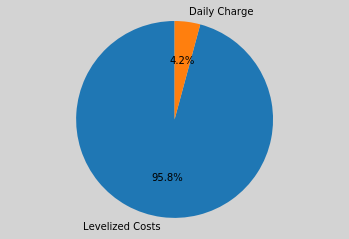

Total roof area of the  building: 599 m2
Total roof area used 544 m2
Percentage: 90.9%
succes
[[175.87397941685305, 250.84428679682452, 158.56889660957773, 53.31349927437586, 42.07403146258991, 16.90529460017397, 0.8488239350331481, 0.6449253884979955, 0.5609403110002298, 3166.62, 305.427, 0.0, 0.0, 305.427, {'Levelized Costs': 3033.558, 'Energy Charge': 0.020000000000038654, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59858069985, 61845.7, 544.491]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185.57940782062036, 207.3796156889483, 152.5557163044383, 35.20097624884287, 33.243430441390245, 14.528181215163649, 0.7603932706835728, 0.6449253884979955, 0.5755441176469376)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 186
                                           a tilt of 35.2
                                           and a gcr of 0.760


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5204851627349854 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 207
                                           a tilt of 33.2
                                           and a gcr of 0.645


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.837212324142456 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 153
                                           a tilt of 14.5
                                           and a gcr of 0.576


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8491179943084717 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 278 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 309.271]


ERROR:ga_logger:Cost: 3204.8


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,205 per year


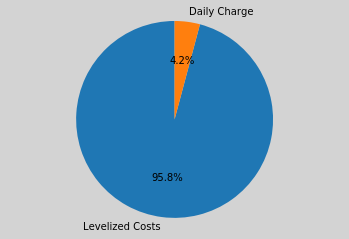

Total roof area of the  building: 599 m2
Total roof area used 537 m2
Percentage: 89.7%
succes
[[185.57940782062036, 207.3796156889483, 152.5557163044383, 35.20097624884287, 33.243430441390245, 14.528181215163649, 0.7603932706835728, 0.6449253884979955, 0.5755441176469376, 3204.8, 309.271, 0.0, 0.0, 309.271, {'Levelized Costs': 3071.751, 'Energy Charge': 0.007000000000232376, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60065869999, 61845.7, 537.355]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (205.16693532136821, 197.2523857002735, 259.6228687420005, 28.680144654866208, 50.87554863456507, 24.10486370592004, 0.5555053599278036, 0.6647159023637118, 0.42099780650789453)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 28.7
                                           and a gcr of 0.556


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2681403160095215 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 197
                                           a tilt of 50.9
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8285257816314697 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 24.1
                                           and a gcr of 0.421


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7941391468048096 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 309 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [303.882, 0.0, 0.0]


ERROR:ga_logger:Cost: 3151.28


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,151 per year


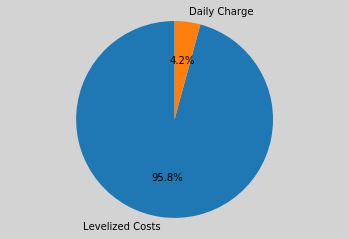

Total roof area of the  building: 599 m2
Total roof area used 547 m2
Percentage: 91.4%
succes
[[205.16693532136821, 197.2523857002735, 259.6228687420005, 28.680144654866208, 50.87554863456507, 24.10486370592004, 0.5555053599278036, 0.6647159023637118, 0.42099780650789453, 3151.28, 303.882, 303.882, 0.0, 0.0, {'Levelized Costs': 3018.228, 'Energy Charge': 0.010000000000161435, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600681125456, 61845.7, 547.038]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (180.85610103783654, 152.35443128995666, 141.56441638361312, 28.419185269390148, 39.92718737250838, 16.618905533175745, 0.3873378354917356, 0.32791614484620857, 0.3093783946898489)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 181
                                           a tilt of 28.4
                                           and a gcr of 0.387


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.456707239151001 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 152
                                           a tilt of 39.9
                                           and a gcr of 0.328


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.89021897315979 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 142
                                           a tilt of 16.6
                                           and a gcr of 0.309


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.92197847366333 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 305 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [231.923, 0.0, 0.0]


ERROR:ga_logger:Cost: 4036.36


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0259 /kWh
Total Cost of the system: $ 4,036 per year


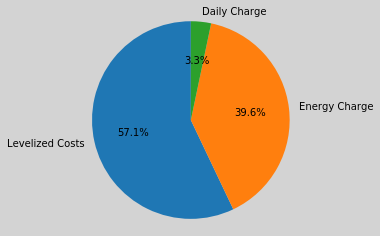

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[180.85610103783654, 152.35443128995666, 141.56441638361312, 28.419185269390148, 39.92718737250838, 16.618905533175745, 0.3873378354917356, 0.32791614484620857, 0.3093783946898489, 4036.36, 231.923, 231.923, 0.0, 0.0, {'Levelized Costs': 2303.5080000000003, 'Energy Charge': 1599.81, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 49077.893091763224, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (264.0196745475839, 225.50701971371325, 177.76944825764826, 37.364580275505915, 48.4762983577403, 29.00795360576206, 0.6409084698055934, 0.6887820544493064, 0.7248519305408936)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 37.4
                                           and a gcr of 0.641


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.385809898376465 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 226
                                           a tilt of 48.5
                                           and a gcr of 0.689


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8618266582489014 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 29.0
                                           and a gcr of 0.725


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8853771686553955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 294 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 124s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 305.751]


ERROR:ga_logger:Cost: 3169.84


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 45,754 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,170 per year


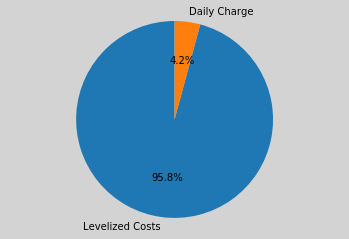

Total roof area of the  building: 599 m2
Total roof area used 422 m2
Percentage: 70.4%
succes
[[264.0196745475839, 225.50701971371325, 177.76944825764826, 37.364580275505915, 48.4762983577403, 29.00795360576206, 0.6409084698055934, 0.6887820544493064, 0.7248519305408936, 3169.84, 305.751, 0.0, 0.0, 305.751, {'Levelized Costs': 3036.7860000000005, 'Energy Charge': 0.011999999999886768, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600104262936, 45754.4, 421.812]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (90.04763033609352, 146.28824134562862, 178.9378806973691, 23.890615740085764, 1.2353323836260817, 7.954982026700042, 0.5992865688243203, 0.8779669714198917, 0.5185333031746143)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 23.9
                                           and a gcr of 0.599


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.449089765548706 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 146
                                           a tilt of 1.2
                                           and a gcr of 0.878


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7556519508361816 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 179
                                           a tilt of 8.0
                                           and a gcr of 0.519


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0046911239624023 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 464 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 367s


ERROR:ga_logger:panel relevance: [0.0, 15.5924, 301.269]


ERROR:ga_logger:Cost: 3280.19


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,280 per year


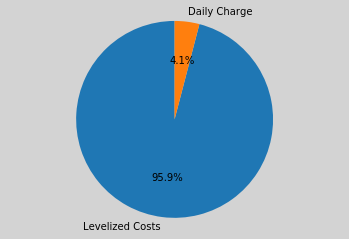

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[90.04763033609352, 146.28824134562862, 178.9378806973691, 23.890615740085764, 1.2353323836260817, 7.954982026700042, 0.5992865688243203, 0.8779669714198917, 0.5185333031746143, 3280.19, 316.8614, 0.0, 15.5924, 301.269, {'Levelized Costs': 3147.129, 'Energy Charge': 0.019000000000346517, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59881307131, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (229.63545420386114, 230.46205177495526, 241.86065123503354, 53.72165358545148, 50.74576540763256, 47.624128685025816, 0.7600171123230056, 0.7989592049756202, 0.8626365514358229)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 53.7
                                           and a gcr of 0.760


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.57337212562561 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 50.7
                                           and a gcr of 0.799


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.739256858825684 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 242
                                           a tilt of 47.6
                                           and a gcr of 0.863


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.978966236114502 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  32 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 797 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 340s


ERROR:ga_logger:panel relevance: [0.0, 386.532, 0.0]


ERROR:ga_logger:Cost: 3972.17


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,972 per year


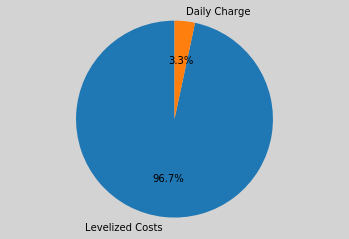

Total roof area of the  building: 599 m2
Total roof area used 484 m2
Percentage: 80.8%
succes
[[229.63545420386114, 230.46205177495526, 241.86065123503354, 53.72165358545148, 50.74576540763256, 47.624128685025816, 0.7600171123230056, 0.7989592049756202, 0.8626365514358229, 3972.17, 386.532, 0.0, 386.532, 0.0, {'Levelized Costs': 3839.1079999999997, 'Energy Charge': 0.020000000000379714, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.604104981874, 61845.7, 483.794]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185.7498453204463, 215.68873169528393, 186.31816608515342, 36.06642275426495, 37.51570328765201, 46.44737017717304, 0.29397544235535844, 0.5734586553143787, 0.8450886075504711)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 186
                                           a tilt of 36.1
                                           and a gcr of 0.294


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.625048875808716 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 216
                                           a tilt of 37.5
                                           and a gcr of 0.573


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.028021812438965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 186
                                           a tilt of 46.4
                                           and a gcr of 0.845


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.060268878936768 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  31 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 742 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 390s


ERROR:ga_logger:panel relevance: [30.1976, 284.459, 0.0]


ERROR:ga_logger:Cost: 3258.28


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,258 per year


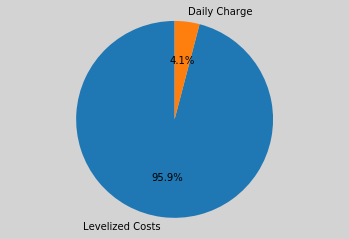

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[185.7498453204463, 215.68873169528393, 186.31816608515342, 36.06642275426495, 37.51570328765201, 46.44737017717304, 0.29397544235535844, 0.5734586553143787, 0.8450886075504711, 3258.28, 314.6566, 30.1976, 284.459, 0.0, {'Levelized Costs': 3125.221, 'Energy Charge': 0.01700000000005275, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60136838408, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (239.57719914044256, 246.2766920172528, 184.08373330564683, 41.9312338302371, 47.19001860316015, 41.41013783078661, 0.6122296607928835, 0.3230425858807059, 0.47919269520516816)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 41.9
                                           and a gcr of 0.612


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.332437515258789 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 246
                                           a tilt of 47.2
                                           and a gcr of 0.323


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.82275390625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 184
                                           a tilt of 41.4
                                           and a gcr of 0.479


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.754870176315308 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  30 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 763 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 334s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 286.922]


ERROR:ga_logger:Cost: 3264.13


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0045 /kWh
Total Cost of the system: $ 3,264 per year


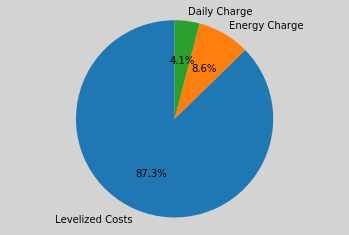

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[239.57719914044256, 246.2766920172528, 184.08373330564683, 41.9312338302371, 47.19001860316015, 41.41013783078661, 0.6122296607928835, 0.3230425858807059, 0.47919269520516816, 3264.13, 286.922, 0.0, 0.0, 286.922, {'Levelized Costs': 2849.771, 'Energy Charge': 281.317, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 59600.58781190084, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (213.91527708780777, 238.0866973763214, 106.9114949026518, 38.735356456565135, 4.798464977667301, 31.519158081410822, 0.2642015663901937, 0.23658136128341967, 0.2915008311324092)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 214
                                           a tilt of 38.7
                                           and a gcr of 0.264


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.527010679244995 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 238
                                           a tilt of 4.8
                                           and a gcr of 0.237


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.067504405975342 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 107
                                           a tilt of 31.5
                                           and a gcr of 0.292


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.655926704406738 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  31 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 766 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 346s


ERROR:ga_logger:panel relevance: [158.194, 0.0, 0.0]


ERROR:ga_logger:Cost: 5417.29


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0600 /kWh
Total Cost of the system: $ 5,417 per year


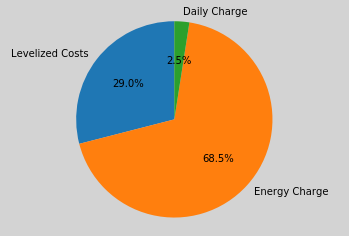

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[213.91527708780777, 238.0866973763214, 106.9114949026518, 38.735356456565135, 4.798464977667301, 31.519158081410822, 0.2642015663901937, 0.23658136128341967, 0.2915008311324092, 5417.29, 158.194, 158.194, 0.0, 0.0, {'Levelized Costs': 1571.2171999999996, 'Energy Charge': 3713.0308000000005, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 32212.582802453533, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (210.8416074822409, 215.24124173482844, 240.6104494006286, 55.65750624904229, 38.075851755321224, 55.868690748841104, 0.8767007790006329, 0.8179635892959691, 0.8301053119446842)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 211
                                           a tilt of 55.7
                                           and a gcr of 0.877


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.285063028335571 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 38.1
                                           and a gcr of 0.818


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.59690523147583 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 241
                                           a tilt of 55.9
                                           and a gcr of 0.830


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.579992055892944 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  30 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 746 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 180s


ERROR:ga_logger:panel relevance: [0.0, 340.915, 0.0]


ERROR:ga_logger:Cost: 3519.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,519 per year


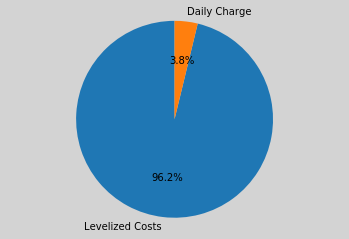

Total roof area of the  building: 599 m2
Total roof area used 417 m2
Percentage: 69.6%
succes
[[210.8416074822409, 215.24124173482844, 240.6104494006286, 55.65750624904229, 38.075851755321224, 55.868690748841104, 0.8767007790006329, 0.8179635892959691, 0.8301053119446842, 3519.09, 340.915, 0.0, 340.915, 0.0, {'Levelized Costs': 3386.03, 'Energy Charge': 0.018000000000199634, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60207852514, 61845.7, 416.785]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (146.51746417132077, 181.9836558645612, 155.23387739851765, 25.48972246731428, 17.58806413671724, 37.29126432753288, 0.6821194710111322, 0.47989072209431183, 0.7361491943291323)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 147
                                           a tilt of 25.5
                                           and a gcr of 0.682


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.324305534362793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 17.6
                                           and a gcr of 0.480


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.794375419616699 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 37.3
                                           and a gcr of 0.736


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.800856590270996 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 460 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 314s


ERROR:ga_logger:panel relevance: [53.1009, 249.982, 0.0]


ERROR:ga_logger:Cost: 3143.34


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,143 per year


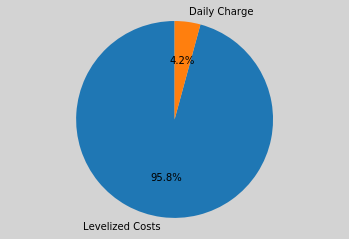

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[146.51746417132077, 181.9836558645612, 155.23387739851765, 25.48972246731428, 17.58806413671724, 37.29126432753288, 0.6821194710111322, 0.47989072209431183, 0.7361491943291323, 3143.34, 303.0829, 53.1009, 249.982, 0.0, {'Levelized Costs': 3010.284, 'Energy Charge': 0.014000000000066848, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59837539022, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (258.69681304115664, 245.80099159477044, 190.749285569384, 27.523762085801245, 44.902374462606026, 31.158523952505412, 0.6288996379068066, 0.8877357342588549, 0.6652720514039839)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 259
                                           a tilt of 27.5
                                           and a gcr of 0.629


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 10.091131448745728 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 246
                                           a tilt of 44.9
                                           and a gcr of 0.888


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.37722110748291 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 191
                                           a tilt of 31.2
                                           and a gcr of 0.665


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.952396392822266 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  32 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 759 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 365s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 303.626]


ERROR:ga_logger:Cost: 3148.73


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,149 per year


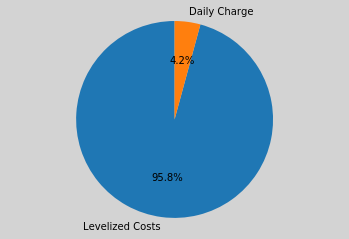

Total roof area of the  building: 599 m2
Total roof area used 456 m2
Percentage: 76.2%
succes
[[258.69681304115664, 245.80099159477044, 190.749285569384, 27.523762085801245, 44.902374462606026, 31.158523952505412, 0.6288996379068066, 0.8877357342588549, 0.6652720514039839, 3148.73, 303.626, 0.0, 0.0, 303.626, {'Levelized Costs': 3015.6749999999997, 'Energy Charge': 0.013000000000147338, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60413804109, 61845.7, 456.394]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (254.81939138160809, 154.8931459139706, 176.1508095581088, 7.227870399586044, 42.40437658142672, 13.477972524023288, 0.4867178608365322, 0.535075824732636, 0.4401605020045719)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 7.2
                                           and a gcr of 0.487


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.610347270965576 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 155
                                           a tilt of 42.4
                                           and a gcr of 0.535


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.823904752731323 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 176
                                           a tilt of 13.5
                                           and a gcr of 0.440


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.665054321289062 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  30 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 720 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 269s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Can not solve this model correctly.


succes
[[254.81939138160809, 154.8931459139706, 176.1508095581088, 7.227870399586044, 42.40437658142672, 13.477972524023288, 0.4867178608365322, 0.535075824732636, 0.4401605020045719, 90000000000, 0, 0.0, 0.0, 0.0, {'Levelized Costs': 0, 'Energy Charge': 10000000000, 'Demand Charge': 0, 'Daily Charge': 0}, 90000000000, 90000000000, 0]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (208.76864393467733, 198.29833214974684, 216.84632504765466, 53.35412604033455, 23.961667661463352, 45.105546911583446, 0.8763088669690271, 0.591217439328956, 0.330643582876493)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 209
                                           a tilt of 53.4
                                           and a gcr of 0.876


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.73544979095459 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 198
                                           a tilt of 24.0
                                           and a gcr of 0.591


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.092437267303467 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 217
                                           a tilt of 45.1
                                           and a gcr of 0.331


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.26056456565857 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  32 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 748 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 441s


ERROR:ga_logger:panel relevance: [0.0, 302.417, 0.0]


ERROR:ga_logger:Cost: 3136.72


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,137 per year


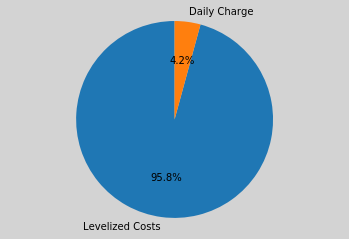

Total roof area of the  building: 599 m2
Total roof area used 512 m2
Percentage: 85.4%
succes
[[208.76864393467733, 198.29833214974684, 216.84632504765466, 53.35412604033455, 23.961667661463352, 45.105546911583446, 0.8763088669690271, 0.591217439328956, 0.330643582876493, 3136.72, 302.417, 0.0, 302.417, 0.0, {'Levelized Costs': 3003.669, 'Energy Charge': 0.009000000000071395, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60054243148, 61845.7, 511.516]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (152.29348615718578, 132.59876682312827, 97.12540847403265, 34.60287746627513, 14.44853573832783, 10.122757623310317, 0.7750898597900057, 0.4045207537289372, 0.22603732753198916)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 152
                                           a tilt of 34.6
                                           and a gcr of 0.775


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.504050731658936 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 133
                                           a tilt of 14.4
                                           and a gcr of 0.405


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.690760374069214 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 97
                                           a tilt of 10.1
                                           and a gcr of 0.226


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.710153341293335 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  31 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 684 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 425s


ERROR:ga_logger:panel relevance: [160.651, 158.367, 0.0]


ERROR:ga_logger:Cost: 3301.61


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,302 per year


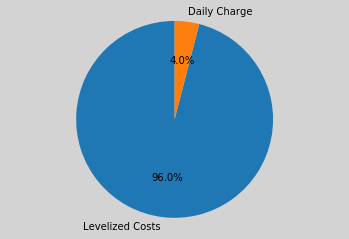

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[152.29348615718578, 132.59876682312827, 97.12540847403265, 34.60287746627513, 14.44853573832783, 10.122757623310317, 0.7750898597900057, 0.4045207537289372, 0.22603732753198916, 3301.61, 319.01800000000003, 160.651, 158.367, 0.0, {'Levelized Costs': 3168.548, 'Energy Charge': 0.020000000000379714, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60084902188, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (257.887333856738, 218.1956117288929, 188.3830223341053, 55.539307127361724, 42.40437658142672, 41.80570199209404, 0.8637862551758496, 0.523038003054406, 0.7295683409230768)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 258
                                           a tilt of 55.5
                                           and a gcr of 0.864


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.3462815284729 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 218
                                           a tilt of 42.4
                                           and a gcr of 0.523


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.443976163864136 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 188
                                           a tilt of 41.8
                                           and a gcr of 0.730


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.65339207649231 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  30 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 710 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 357s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 314.083]


ERROR:ga_logger:Cost: 3252.59


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,253 per year


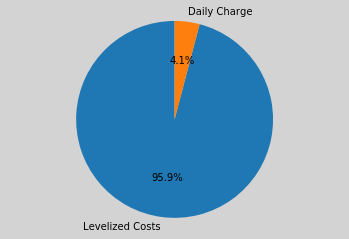

Total roof area of the  building: 599 m2
Total roof area used 431 m2
Percentage: 71.9%
succes
[[257.887333856738, 218.1956117288929, 188.3830223341053, 55.539307127361724, 42.40437658142672, 41.80570199209404, 0.8637862551758496, 0.523038003054406, 0.7295683409230768, 3252.59, 314.083, 0.0, 0.0, 314.083, {'Levelized Costs': 3119.532, 'Energy Charge': 0.016000000000246928, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601446985274, 61845.7, 430.506]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (139.95350752503117, 159.30814233133714, 101.07861155182484, 19.525800052955933, 26.122227910087446, 11.166198479997803, 0.3813297150127066, 0.48588088800815193, 0.20859951268246696)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 19.5
                                           and a gcr of 0.381


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.554636716842651 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 159
                                           a tilt of 26.1
                                           and a gcr of 0.486


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.854365110397339 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 101
                                           a tilt of 11.2
                                           and a gcr of 0.209


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.726608991622925 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  31 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 749 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 332s


ERROR:ga_logger:panel relevance: [0.0, 290.927, 0.0]


ERROR:ga_logger:Cost: 3225.5


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0033 /kWh
Total Cost of the system: $ 3,226 per year


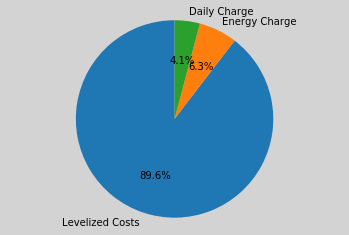

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[139.95350752503117, 159.30814233133714, 101.07861155182484, 19.525800052955933, 26.122227910087446, 11.166198479997803, 0.3813297150127066, 0.48588088800815193, 0.20859951268246696, 3225.5, 290.927, 0.0, 290.927, 0.0, {'Levelized Costs': 2889.546, 'Energy Charge': 202.91200000000015, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 60226.322697799966, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (258.7849023248049, 222.37093173622753, 186.43445825885186, 26.18531710288747, 47.928282831851924, 25.782190515538474, 0.8008680745787244, 0.8962382471790313, 0.8978311699289662)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 259
                                           a tilt of 26.2
                                           and a gcr of 0.801


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.330207109451294 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 222
                                           a tilt of 47.9
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.560814380645752 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 186
                                           a tilt of 25.8
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.151087999343872 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  30 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 696 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 381s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 319.078]


ERROR:ga_logger:Cost: 3302.2


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,302 per year


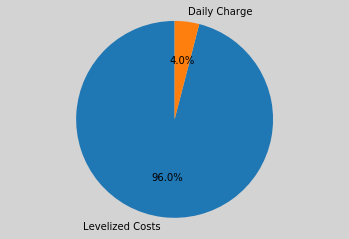

Total roof area of the  building: 599 m2
Total roof area used 355 m2
Percentage: 59.4%
succes
[[258.7849023248049, 222.37093173622753, 186.43445825885186, 26.18531710288747, 47.928282831851924, 25.782190515538474, 0.8008680745787244, 0.8962382471790313, 0.8978311699289662, 3302.2, 319.078, 0.0, 0.0, 319.078, {'Levelized Costs': 3169.144, 'Energy Charge': 0.014000000000010004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60243088859, 61845.7, 355.387]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (256.4394667056803, 119.29724910991254, 174.51915718760506, 5.875154919186786, 21.042969252943177, 5.199692161710327, 0.6027153101326781, 0.8451037789734809, 0.5276750205797958)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 256
                                           a tilt of 5.9
                                           and a gcr of 0.603


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.603464126586914 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 119
                                           a tilt of 21.0
                                           and a gcr of 0.845


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.707343578338623 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 5.2
                                           and a gcr of 0.528


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.733664989471436 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  31 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 730 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 328s


ERROR:ga_logger:panel relevance: [0.0, 20.0302, 303.445]


ERROR:ga_logger:Cost: 3345.88


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,346 per year


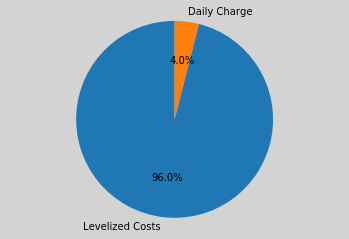

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[256.4394667056803, 119.29724910991254, 174.51915718760506, 5.875154919186786, 21.042969252943177, 5.199692161710327, 0.6027153101326781, 0.8451037789734809, 0.5276750205797958, 3345.88, 323.4752, 0.0, 20.0302, 303.445, {'Levelized Costs': 3212.826, 'Energy Charge': 0.012000000000057298, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59815014178, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (199.14103168692807, 198.1348600674199, 203.380681281162, 46.858997847481604, 26.47760005144395, 47.96435248017743, 0.827680474975082, 0.6989554741252766, 0.5899120242884863)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 199
                                           a tilt of 46.9
                                           and a gcr of 0.828


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.753894090652466 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 198
                                           a tilt of 26.5
                                           and a gcr of 0.699


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.005347728729248 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 203
                                           a tilt of 48.0
                                           and a gcr of 0.590


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.891608476638794 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  31 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 704 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 355s


ERROR:ga_logger:panel relevance: [0.0, 307.606, 0.0]


ERROR:ga_logger:Cost: 3188.26


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,188 per year


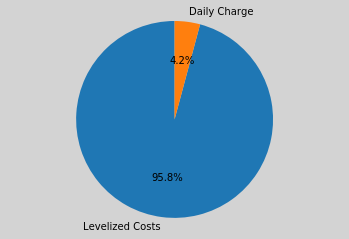

Total roof area of the  building: 599 m2
Total roof area used 440 m2
Percentage: 73.5%
succes
[[199.14103168692807, 198.1348600674199, 203.380681281162, 46.858997847481604, 26.47760005144395, 47.96435248017743, 0.827680474975082, 0.6989554741252766, 0.5899120242884863, 3188.26, 307.606, 0.0, 307.606, 0.0, {'Levelized Costs': 3055.2120000000004, 'Energy Charge': 0.005999999999914962, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60174939135, 61845.7, 440.094]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (153.96053313903627, 156.10787898950727, 101.07861155182484, 1.9519261531793295, 10.310542215682487, 15.948664215338848, 0.4671613200060464, 0.48588088800815193, 0.2613241016070206)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 154
                                           a tilt of 2.0
                                           and a gcr of 0.467


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.195647954940796 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 156
                                           a tilt of 10.3
                                           and a gcr of 0.486


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.46111512184143 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 101
                                           a tilt of 15.9
                                           and a gcr of 0.261


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 8.620182275772095 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  30 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 778 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 321s


ERROR:ga_logger:panel relevance: [0.0, 290.927, 0.0]


ERROR:ga_logger:Cost: 3566.96


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0088 /kWh
Total Cost of the system: $ 3,567 per year


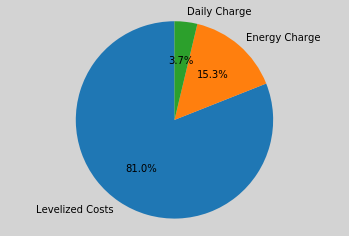

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[153.96053313903627, 156.10787898950727, 101.07861155182484, 1.9519261531793295, 10.310542215682487, 15.948664215338848, 0.4671613200060464, 0.48588088800815193, 0.2613241016070206, 3566.96, 290.927, 0.0, 290.927, 0.0, {'Levelized Costs': 2889.543, 'Energy Charge': 544.3750000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 57501.14138550004, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (221.9457954650393, 212.68606549593153, 155.13130038312488, 22.862945378620047, 40.13746755715265, 55.93855673091858, 0.8871289325585261, 0.26699159592449945, 0.651334701473031)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 222
                                           a tilt of 22.9
                                           and a gcr of 0.887


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.76542067527771 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 213
                                           a tilt of 40.1
                                           and a gcr of 0.267


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0634045600891113 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 55.9
                                           and a gcr of 0.651


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9646294116973877 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 206 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 136s


ERROR:ga_logger:panel relevance: [241.545, 87.1687, 0.0]


ERROR:ga_logger:Cost: 3397.9


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,398 per year


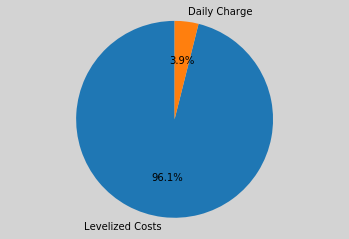

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[221.9457954650393, 212.68606549593153, 155.13130038312488, 22.862945378620047, 40.13746755715265, 55.93855673091858, 0.8871289325585261, 0.26699159592449945, 0.651334701473031, 3397.9, 328.7137, 241.545, 87.1687, 0.0, {'Levelized Costs': 3264.8370000000004, 'Energy Charge': 0.020999999999787633, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60181831347, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (90.93575746974193, 166.914544787679, 91.44189717893023, 2.0852903604470185, 1.002136759567028, 54.97401155793125, 0.7075558610187439, 0.23201102390995848, 0.4284222021604751)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 2.1
                                           and a gcr of 0.708


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.97078275680542 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 167
                                           a tilt of 1.0
                                           and a gcr of 0.232


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.127166986465454 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 91
                                           a tilt of 55.0
                                           and a gcr of 0.428


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.929731845855713 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 241 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 177s


ERROR:ga_logger:panel relevance: [292.019, 43.1648, 0.0]


ERROR:ga_logger:Cost: 3462.17


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,462 per year


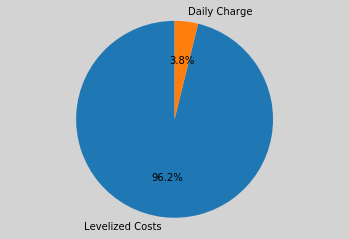

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[90.93575746974193, 166.914544787679, 91.44189717893023, 2.0852903604470185, 1.002136759567028, 54.97401155793125, 0.7075558610187439, 0.23201102390995848, 0.4284222021604751, 3462.17, 335.1838, 292.019, 43.1648, 0.0, {'Levelized Costs': 3329.113, 'Energy Charge': 0.015000000000327418, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600838879625, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (211.70898902621522, 205.86493308147627, 148.65906570915809, 27.934571429510537, 34.60068199958563, 30.282373009159922, 0.6137873164348311, 0.6086155836858781, 0.8516255498917079)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 212
                                           a tilt of 27.9
                                           and a gcr of 0.614


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.605424642562866 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 206
                                           a tilt of 34.6
                                           and a gcr of 0.609


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.904383897781372 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 149
                                           a tilt of 30.3
                                           and a gcr of 0.852


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.000603437423706 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 269 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 112s


ERROR:ga_logger:panel relevance: [0.0, 309.862, 0.0]


ERROR:ga_logger:Cost: 3210.67


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,211 per year


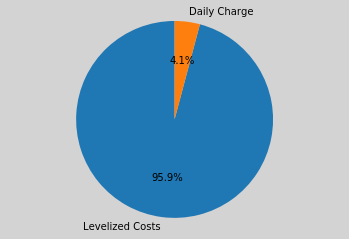

Total roof area of the  building: 599 m2
Total roof area used 509 m2
Percentage: 85.0%
succes
[[211.70898902621522, 205.86493308147627, 148.65906570915809, 27.934571429510537, 34.60068199958563, 30.282373009159922, 0.6137873164348311, 0.6086155836858781, 0.8516255498917079, 3210.67, 309.862, 0.0, 309.862, 0.0, {'Levelized Costs': 3077.6079999999997, 'Energy Charge': 0.020000000000436557, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6034841005, 61845.7, 509.127]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (144.06344456997803, 97.0396078307234, 101.76386757543759, 21.609671332719014, 34.78353886140009, 22.162108516334282, 0.5028030029384544, 0.4853557740564632, 0.6476426512884921)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 144
                                           a tilt of 21.6
                                           and a gcr of 0.503


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.521024465560913 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 97
                                           a tilt of 34.8
                                           and a gcr of 0.485


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.838679075241089 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 102
                                           a tilt of 22.2
                                           and a gcr of 0.648


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8852901458740234 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 273 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [262.09, 0.0, 50.1952]


ERROR:ga_logger:Cost: 3234.73


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,235 per year


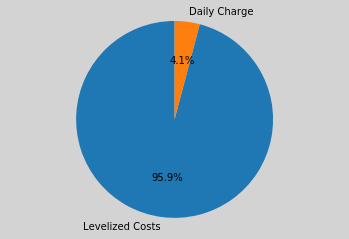

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[144.06344456997803, 97.0396078307234, 101.76386757543759, 21.609671332719014, 34.78353886140009, 22.162108516334282, 0.5028030029384544, 0.4853557740564632, 0.6476426512884921, 3234.73, 312.2852, 262.09, 0.0, 50.1952, {'Levelized Costs': 3101.669, 'Energy Charge': 0.019000000000119144, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59924129991, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (156.4859394024894, 193.08978459066452, 153.8993323841854, 46.75574131408665, 24.726021043160646, 49.49223098210712, 0.8941973364514282, 0.7585896627272223, 0.6835306021545254)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 156
                                           a tilt of 46.8
                                           and a gcr of 0.894


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5680956840515137 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 193
                                           a tilt of 24.7
                                           and a gcr of 0.759


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.91633939743042 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 154
                                           a tilt of 49.5
                                           and a gcr of 0.684


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.859333038330078 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 272 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [0.0, 309.332, 0.0]


ERROR:ga_logger:Cost: 3205.41


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,205 per year


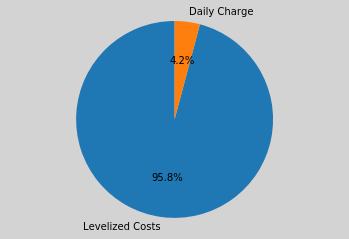

Total roof area of the  building: 599 m2
Total roof area used 408 m2
Percentage: 68.1%
succes
[[156.4859394024894, 193.08978459066452, 153.8993323841854, 46.75574131408665, 24.726021043160646, 49.49223098210712, 0.8941973364514282, 0.7585896627272223, 0.6835306021545254, 3205.41, 309.332, 0.0, 309.332, 0.0, {'Levelized Costs': 3072.35, 'Energy Charge': 0.018000000000029104, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60112092465, 61845.7, 407.773]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (135.03275088372624, 174.88835346073182, 97.99631568196551, 21.326454335827947, 17.583416586178753, 33.65680546437215, 0.888457154502834, 0.4963371112737142, 0.24712487767989066)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 21.3
                                           and a gcr of 0.888


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5894970893859863 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 17.6
                                           and a gcr of 0.496


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8705928325653076 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 98
                                           a tilt of 33.7
                                           and a gcr of 0.247


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.941408395767212 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 282 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 99s


ERROR:ga_logger:panel relevance: [13.3054, 289.755, 0.0]


ERROR:ga_logger:Cost: 3143.11


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,143 per year


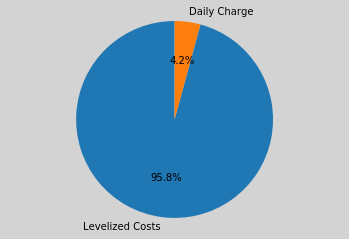

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[135.03275088372624, 174.88835346073182, 97.99631568196551, 21.326454335827947, 17.583416586178753, 33.65680546437215, 0.888457154502834, 0.4963371112737142, 0.24712487767989066, 3143.11, 303.0604, 13.3054, 289.755, 0.0, {'Levelized Costs': 3010.06, 'Energy Charge': 0.00800000000037926, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60141582829, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (212.8893065896575, 177.8515637169249, 257.794390202338, 20.81678665129028, 10.90493423531709, 44.43227240911816, 0.5996453769042777, 0.8704937760425642, 0.5077092572081592)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 213
                                           a tilt of 20.8
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6865074634552 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 10.9
                                           and a gcr of 0.870


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.708489179611206 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 258
                                           a tilt of 44.4
                                           and a gcr of 0.508


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.782519578933716 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 291 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 110s


ERROR:ga_logger:panel relevance: [309.909, 0.0, 0.0]


ERROR:ga_logger:Cost: 3211.14


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,211 per year


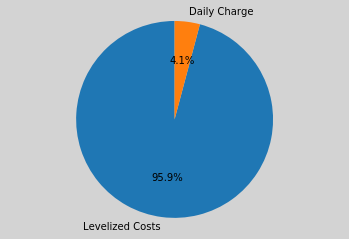

Total roof area of the  building: 599 m2
Total roof area used 517 m2
Percentage: 86.3%
succes
[[212.8893065896575, 177.8515637169249, 257.794390202338, 20.81678665129028, 10.90493423531709, 44.43227240911816, 0.5996453769042777, 0.8704937760425642, 0.5077092572081592, 3211.14, 309.909, 309.909, 0.0, 0.0, {'Levelized Costs': 3078.0899999999997, 'Energy Charge': 0.008000000000208729, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59988123789, 61845.7, 516.821]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (201.32748873723062, 171.3301831597335, 215.0895575486224, 2.549969966440743, 10.947620057677133, 15.229301805127902, 0.45323437827534524, 0.7179176332227353, 0.3266389510108206)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 201
                                           a tilt of 2.5
                                           and a gcr of 0.453


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.359250783920288 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 171
                                           a tilt of 10.9
                                           and a gcr of 0.718


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.786285400390625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 15.2
                                           and a gcr of 0.327


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.100079298019409 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 302 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [0.0, 214.551, 97.9622]


ERROR:ga_logger:Cost: 3237.0


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,237 per year


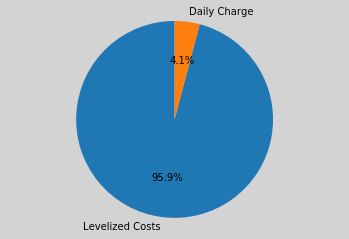

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[201.32748873723062, 171.3301831597335, 215.0895575486224, 2.549969966440743, 10.947620057677133, 15.229301805127902, 0.45323437827534524, 0.7179176332227353, 0.3266389510108206, 3237.0, 312.5132, 0.0, 214.551, 97.9622, {'Levelized Costs': 3103.9410000000003, 'Energy Charge': 0.01700000000005275, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60249923704, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (211.73547940139755, 224.30012406141915, 263.6016039207204, 27.203119061461038, 52.27863468990671, 25.16568988504828, 0.39271431854062766, 0.4368736360683147, 0.7163952246755938)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 212
                                           a tilt of 27.2
                                           and a gcr of 0.393


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6524393558502197 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 224
                                           a tilt of 52.3
                                           and a gcr of 0.437


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.855308771133423 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 264
                                           a tilt of 25.2
                                           and a gcr of 0.716


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.151517868041992 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 299 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 120s


ERROR:ga_logger:panel relevance: [97.553, 0.0, 250.992]


ERROR:ga_logger:Cost: 3594.88


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,595 per year


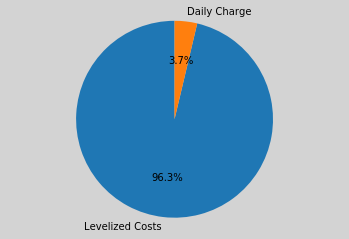

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[211.73547940139755, 224.30012406141915, 263.6016039207204, 27.203119061461038, 52.27863468990671, 25.16568988504828, 0.39271431854062766, 0.4368736360683147, 0.7163952246755938, 3594.88, 348.54499999999996, 97.553, 0.0, 250.992, {'Levelized Costs': 3461.819, 'Energy Charge': 0.01900000000023283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601347765, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (159.75002673090503, 164.70545641882907, 258.50767987688874, 20.391710301288754, 49.2331129753839, 19.486422291543782, 0.5217110912947519, 0.35911284019317624, 0.329935073206331)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 20.4
                                           and a gcr of 0.522


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7413854598999023 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 49.2
                                           and a gcr of 0.359


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.995264768600464 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 259
                                           a tilt of 19.5
                                           and a gcr of 0.330


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1362650394439697 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 283 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [301.785, 0.0, 0.0]


ERROR:ga_logger:Cost: 3130.44


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,130 per year


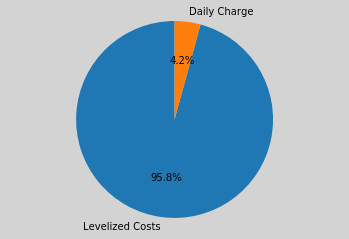

Total roof area of the  building: 599 m2
Total roof area used 578 m2
Percentage: 96.6%
succes
[[159.75002673090503, 164.70545641882907, 258.50767987688874, 20.391710301288754, 49.2331129753839, 19.486422291543782, 0.5217110912947519, 0.35911284019317624, 0.329935073206331, 3130.44, 301.785, 301.785, 0.0, 0.0, {'Levelized Costs': 2997.3830000000003, 'Energy Charge': 0.015000000000043201, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60114599997, 61845.7, 578.452]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (261.9836970410343, 150.6063230975439, 181.28772440546481, 36.94301054180247, 39.69535554065842, 21.270587475021873, 0.5775459539668001, 0.8921811117692608, 0.5975126090451858)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 36.9
                                           and a gcr of 0.578


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7491228580474854 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 151
                                           a tilt of 39.7
                                           and a gcr of 0.892


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.008326530456543 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 21.3
                                           and a gcr of 0.598


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9529242515563965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 288 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 299.641]


ERROR:ga_logger:Cost: 3109.15


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,109 per year


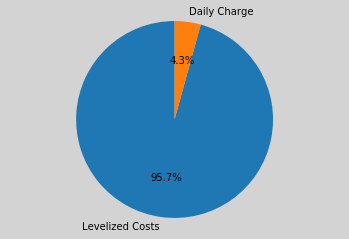

Total roof area of the  building: 599 m2
Total roof area used 501 m2
Percentage: 83.8%
succes
[[261.9836970410343, 150.6063230975439, 181.28772440546481, 36.94301054180247, 39.69535554065842, 21.270587475021873, 0.5775459539668001, 0.8921811117692608, 0.5975126090451858, 3109.15, 299.641, 0.0, 0.0, 299.641, {'Levelized Costs': 2976.1059999999998, 'Energy Charge': 0.0020000000002369234, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60047260532, 61845.7, 501.48]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (255.51833424642564, 219.98128516395255, 168.43677619458384, 1.3044990317013525, 45.679414271205815, 11.252531562922776, 0.45213969933437775, 0.5153340206371448, 0.5185333031746143)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 256
                                           a tilt of 1.3
                                           and a gcr of 0.452


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.64782452583313 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 220
                                           a tilt of 45.7
                                           and a gcr of 0.515


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9965689182281494 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 11.3
                                           and a gcr of 0.519


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9044129848480225 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 284 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 170s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 310.308]


ERROR:ga_logger:Cost: 3215.1


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,215 per year


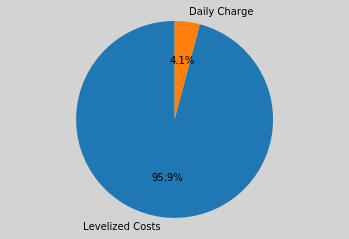

Total roof area of the  building: 599 m2
Total roof area used 598 m2
Percentage: 99.9%
succes
[[255.51833424642564, 219.98128516395255, 168.43677619458384, 1.3044990317013525, 45.679414271205815, 11.252531562922776, 0.45213969933437775, 0.5153340206371448, 0.5185333031746143, 3215.1, 310.308, 0.0, 0.0, 310.308, {'Levelized Costs': 3082.052, 'Energy Charge': 0.0060000000000854925, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60087574989, 61845.7, 598.434]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (199.0365663752282, 180.09383615010225, 115.2235273786681, 26.708040284744715, 52.52934143144614, 50.439107086497614, 0.6063864071527141, 0.5423313750163374, 0.641606083214713)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 199
                                           a tilt of 26.7
                                           and a gcr of 0.606


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.901890277862549 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 52.5
                                           and a gcr of 0.542


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.087360382080078 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 50.4
                                           and a gcr of 0.642


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1082401275634766 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 228 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 98s


ERROR:ga_logger:panel relevance: [303.053, 0.0, 0.0]


ERROR:ga_logger:Cost: 3143.04


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,143 per year


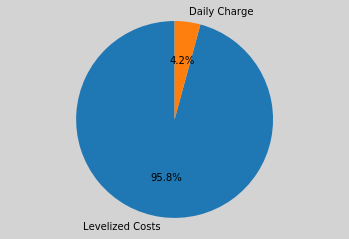

Total roof area of the  building: 599 m2
Total roof area used 500 m2
Percentage: 83.5%
succes
[[199.0365663752282, 180.09383615010225, 115.2235273786681, 26.708040284744715, 52.52934143144614, 50.439107086497614, 0.6063864071527141, 0.5423313750163374, 0.641606083214713, 3143.04, 303.053, 303.053, 0.0, 0.0, {'Levelized Costs': 3009.9889999999996, 'Energy Charge': 0.009000000000355612, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60112214047, 61845.7, 499.769]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (121.22569016874968, 100.87616979347449, 256.8631574263469, 23.29987166399278, 50.596922230030856, 14.251952224740059, 0.3122338219051727, 0.7077146373026733, 0.5328773098846388)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 121
                                           a tilt of 23.3
                                           and a gcr of 0.312


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.075410604476929 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 101
                                           a tilt of 50.6
                                           and a gcr of 0.708


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.904219388961792 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 257
                                           a tilt of 14.3
                                           and a gcr of 0.533


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.994879961013794 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 282 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 319.067]


ERROR:ga_logger:Cost: 3699.76


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0064 /kWh
Total Cost of the system: $ 3,700 per year


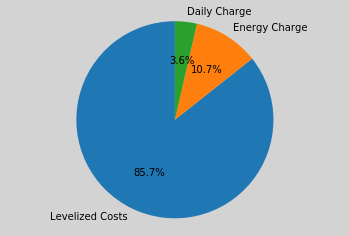

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[121.22569016874968, 100.87616979347449, 256.8631574263469, 23.29987166399278, 50.596922230030856, 14.251952224740059, 0.3122338219051727, 0.7077146373026733, 0.5328773098846388, 3699.76, 319.067, 0.0, 0.0, 319.067, {'Levelized Costs': 3169.038, 'Energy Charge': 397.6800000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 58671.85159214856, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (215.73099277179395, 152.05485925592444, 213.67046841765486, 29.735089576862094, 38.96767245168896, 29.615278331173137, 0.746677438063155, 0.670266360745429, 0.316557169346434)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 216
                                           a tilt of 29.7
                                           and a gcr of 0.747


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.543016195297241 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 152
                                           a tilt of 39.0
                                           and a gcr of 0.670


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.889887809753418 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 214
                                           a tilt of 29.6
                                           and a gcr of 0.317


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9589293003082275 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 293 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 106s


ERROR:ga_logger:panel relevance: [0.0, 237.731, 77.2652]


ERROR:ga_logger:Cost: 3261.67


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,262 per year


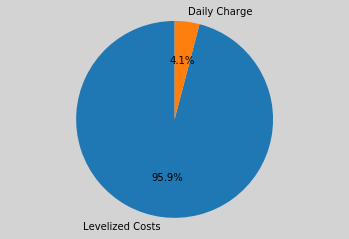

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[215.73099277179395, 152.05485925592444, 213.67046841765486, 29.735089576862094, 38.96767245168896, 29.615278331173137, 0.746677438063155, 0.670266360745429, 0.316557169346434, 3261.67, 314.9962, 0.0, 237.731, 77.2652, {'Levelized Costs': 3128.6099999999997, 'Energy Charge': 0.018000000000427008, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601362886126, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (186.68877576869144, 134.9984902132084, 184.26872449212797, 28.680144654866208, 1.4381874074103975, 15.034936898692296, 0.41076677855404553, 0.6118703618805833, 0.4646327491638204)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 187
                                           a tilt of 28.7
                                           and a gcr of 0.411


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.682379961013794 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 1.4
                                           and a gcr of 0.612


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6894636154174805 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 184
                                           a tilt of 15.0
                                           and a gcr of 0.465


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8849120140075684 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 241 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 278.204]


ERROR:ga_logger:Cost: 3555.06


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0107 /kWh
Total Cost of the system: $ 3,555 per year


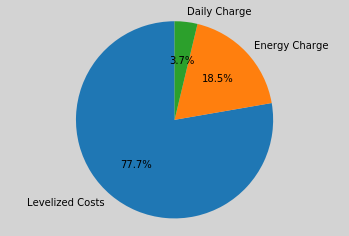

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[186.68877576869144, 134.9984902132084, 184.26872449212797, 28.680144654866208, 1.4381874074103975, 15.034936898692296, 0.41076677855404553, 0.6118703618805833, 0.4646327491638204, 3555.06, 278.204, 0.0, 0.0, 278.204, {'Levelized Costs': 2763.182, 'Energy Charge': 658.8360000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 56587.66360024071, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (245.16627618694972, 230.80238289216072, 223.60180193716383, 55.916177838633324, 37.47827823677624, 49.659471431733024, 0.6968341083635892, 0.5734586553143787, 0.8667236621158462)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 55.9
                                           and a gcr of 0.697


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6027369499206543 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 231
                                           a tilt of 37.5
                                           and a gcr of 0.573


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7806105613708496 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 224
                                           a tilt of 49.7
                                           and a gcr of 0.867


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.815824031829834 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 288 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 111s


ERROR:ga_logger:panel relevance: [0.0, 333.54, 0.0]


ERROR:ga_logger:Cost: 3445.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,446 per year


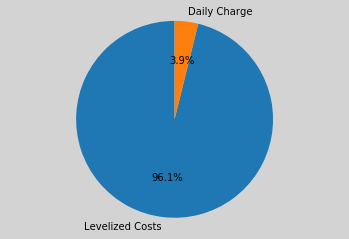

Total roof area of the  building: 599 m2
Total roof area used 582 m2
Percentage: 97.1%
succes
[[245.16627618694972, 230.80238289216072, 223.60180193716383, 55.916177838633324, 37.47827823677624, 49.659471431733024, 0.6968341083635892, 0.5734586553143787, 0.8667236621158462, 3445.85, 333.54, 0.0, 333.54, 0.0, {'Levelized Costs': 3312.7980000000002, 'Energy Charge': 0.009999999999990905, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60271406078, 61845.7, 581.629]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (227.52547131935523, 214.91661532972876, 141.46071491972586, 7.079209015988193, 1.1502971817021617, 28.314637381062244, 0.663848421438804, 0.4350196766540987, 0.6279522169783308)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 228
                                           a tilt of 7.1
                                           and a gcr of 0.664


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.069178104400635 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 215
                                           a tilt of 1.2
                                           and a gcr of 0.435


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.4950103759765625 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 141
                                           a tilt of 28.3
                                           and a gcr of 0.628


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.802933692932129 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 280 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 108s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 314.741]


ERROR:ga_logger:Cost: 3259.13


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,259 per year


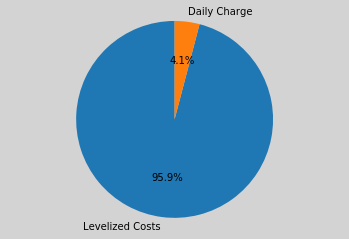

Total roof area of the  building: 599 m2
Total roof area used 501 m2
Percentage: 83.7%
succes
[[227.52547131935523, 214.91661532972876, 141.46071491972586, 7.079209015988193, 1.1502971817021617, 28.314637381062244, 0.663848421438804, 0.4350196766540987, 0.6279522169783308, 3259.13, 314.741, 0.0, 0.0, 314.741, {'Levelized Costs': 3126.082, 'Energy Charge': 0.006000000000256023, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60122590007, 61845.7, 501.218]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (258.4390071738337, 153.86685333413854, 198.20412075283508, 5.857332004111125, 30.690608370270933, 40.86436426981788, 0.8657711719840435, 0.8666079034581334, 0.8560574601249831)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 258
                                           a tilt of 5.9
                                           and a gcr of 0.866


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.767669677734375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 154
                                           a tilt of 30.7
                                           and a gcr of 0.867


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.758665084838867 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 198
                                           a tilt of 40.9
                                           and a gcr of 0.856


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.84323787689209 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 279 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 101s


ERROR:ga_logger:panel relevance: [0.0, 329.888, 0.0]


ERROR:ga_logger:Cost: 3409.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,410 per year


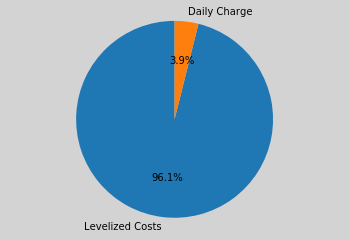

Total roof area of the  building: 599 m2
Total roof area used 381 m2
Percentage: 63.6%
succes
[[258.4390071738337, 153.86685333413854, 198.20412075283508, 5.857332004111125, 30.690608370270933, 40.86436426981788, 0.8657711719840435, 0.8666079034581334, 0.8560574601249831, 3409.57, 329.888, 0.0, 329.888, 0.0, {'Levelized Costs': 3276.52, 'Energy Charge': 0.008000000000492946, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601473009956, 61845.7, 380.665]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (192.40872279885335, 111.51373985342043, 98.27585737615749, 3.6450317400053436, 19.541321796830353, 1.3572738018894155, 0.7216377237329005, 0.30609586909031594, 0.8144742440437118)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 192
                                           a tilt of 3.6
                                           and a gcr of 0.722


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 14.996358156204224 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 112
                                           a tilt of 19.5
                                           and a gcr of 0.306


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8103697299957275 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 98
                                           a tilt of 1.4
                                           and a gcr of 0.814


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6464955806732178 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 246 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [247.322, 78.3722, 0.0]


ERROR:ga_logger:Cost: 3367.92


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,368 per year


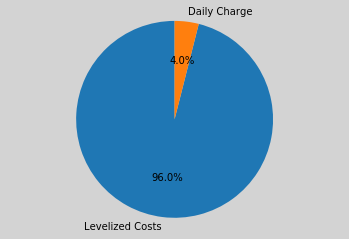

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[192.40872279885335, 111.51373985342043, 98.27585737615749, 3.6450317400053436, 19.541321796830353, 1.3572738018894155, 0.7216377237329005, 0.30609586909031594, 0.8144742440437118, 3367.92, 325.6942, 247.322, 78.3722, 0.0, {'Levelized Costs': 3234.8619999999996, 'Energy Charge': 0.016000000000417458, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60216451005, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (244.636008110607, 262.07554482507885, 197.69161858689307, 30.27067102763195, 18.73305423771013, 51.35267664227359, 0.8566525359972887, 0.8252014435328205, 0.7707966826866985)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 30.3
                                           and a gcr of 0.857


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6984355449676514 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 262
                                           a tilt of 18.7
                                           and a gcr of 0.825


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8274171352386475 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 198
                                           a tilt of 51.4
                                           and a gcr of 0.771


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8344357013702393 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 176 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 113s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 337.708]


ERROR:ga_logger:Cost: 3487.24


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,487 per year


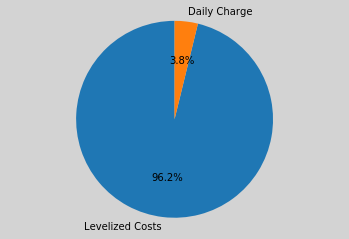

Total roof area of the  building: 599 m2
Total roof area used 438 m2
Percentage: 73.2%
succes
[[244.636008110607, 262.07554482507885, 197.69161858689307, 30.27067102763195, 18.73305423771013, 51.35267664227359, 0.8566525359972887, 0.8252014435328205, 0.7707966826866985, 3487.24, 337.708, 0.0, 0.0, 337.708, {'Levelized Costs': 3354.183, 'Energy Charge': 0.014999999999815827, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60218106514, 61845.7, 438.128]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (113.41624795093117, 166.2050373728433, 151.15234316727893, 28.47420483837888, 14.719466891993422, 39.64890564586244, 0.4337614886800225, 0.7454185180679711, 0.5396142578659069)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 113
                                           a tilt of 28.5
                                           and a gcr of 0.434


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.678462505340576 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 166
                                           a tilt of 14.7
                                           and a gcr of 0.745


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.793337345123291 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 151
                                           a tilt of 39.6
                                           and a gcr of 0.540


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8250083923339844 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 147 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 115s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 310.596]


ERROR:ga_logger:Cost: 3217.96


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,218 per year


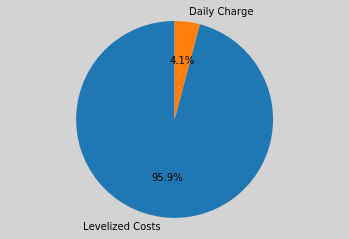

Total roof area of the  building: 599 m2
Total roof area used 576 m2
Percentage: 96.1%
succes
[[113.41624795093117, 166.2050373728433, 151.15234316727893, 28.47420483837888, 14.719466891993422, 39.64890564586244, 0.4337614886800225, 0.7454185180679711, 0.5396142578659069, 3217.96, 310.596, 0.0, 0.0, 310.596, {'Levelized Costs': 3084.901, 'Energy Charge': 0.017000000000280124, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59927839016, 61845.7, 575.589]]


ERROR:optimizer_logger:100


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:Runs_logger:Run nr 5 using opt-method ga-50 with 100 evalautions took: (min)


ERROR:Runs_logger:950.6961482365926


In [29]:
# GA
if (opt_method =="ga-20"):
    init_pop=20
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-50"):
    init_pop=50
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-net"):
    # implementation of the max_evaluations only works starting from 6 or higher
    # also if you set this max_evalutions to 10 it will stop after 9 evaluations
    # therefore I have added 1 to the max_evaluations. 
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE-NET")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-cost"):
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE")
    pvoptimizer.processGA(ga_fina)

# runtime in seconds
endtime=time.time()-t1
mintime=endtime/60
lrun.error("Run nr {} using opt-method {} with {} evalautions took: (min)".format(run_i,opt_method,number_of_opt_evaluations))
lrun.error(mintime)